<a href="https://colab.research.google.com/github/mahnoorcheema/Dog-Breed-Identification/blob/master/CSI4106_Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Dog Breed Identification Challenge

## Install Kaggle 

In [0]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 245kB 5.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


##Import Libraries

In [0]:
import os
import time
from datetime import timedelta
import math
import tensorflow as tf
import scipy.misc
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from IPython.display import display
import pandas as pd
from zipfile import ZipFile
from io import BytesIO

##Kaggle Pre-Processing
Link to account and download files (training set, test set, labels)

**Delete for Submission**

In [0]:
#Links to account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahnoorcheema","key":"51dd5a6107bb02e5d0a2ec3e15393a68"}'}

In [0]:
#Checks to see if the file is in the directory
ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Nov 26 17:49 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Downloads data from Kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dog-breed-identification


  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 53.0MB/s]
  0% 0.00/281k [00:00<?, ?B/s]
100% 281k/281k [00:00<00:00, 84.1MB/s]
 97% 336M/346M [00:04<00:00, 60.4MB/s]
100% 346M/346M [00:04<00:00, 83.1MB/s]
 96% 331M/345M [00:02<00:00, 143MB/s]
100% 345M/345M [00:03<00:00, 115MB/s]


In [0]:
!unzip all.zip

unzip:  cannot find or open all.zip, all.zip.zip or all.zip.ZIP.


##Normalize Data

In [0]:
#Uncompress Train and Test files
archive_train = ZipFile("train.zip", 'r')
archive_test = ZipFile("test.zip", 'r')

In [0]:
# Creates pickle file of images 
###############
def normalize_data(archivezip, width, height, save_name):
     #We choose the archive (zip file) + the new width and height for all the image which will be reshaped
    s = (len(archivezip.namelist()[:])-1, width, height,3) #width x height = number of features because images are width x height pixels
    allImage = np.zeros(s)

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((width, height))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
    
    #we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )

In [0]:
image_resize = 60
#creates pickle file, this step can take several minutes
start = time.time()
normalize_data(archivezip = archive_train, 
               width = image_resize, 
               height = image_resize,
               save_name = "train")
normalize_data(archivezip = archive_test,
               width = image_resize,
               height = image_resize,
               save_name = "test")
end = time.time()
print("Time Taken:",end-start)

Time Taken: 107.76319146156311


In [0]:
#load training data and show it's shape
train = pickle.load( open( "train.p", "rb" ) )
print("The shape of the training data is: " , train.shape)

#load test data and show it's shape
test = pickle.load( open( "test.p", "rb" ) )
print("The shape of the test data is: " , test.shape)


The shape of the training data is:  (10222, 60, 60, 3)
The shape of the test data is:  (10357, 60, 60, 3)


In [0]:
#Retrieve labels from the CSV file provided
labels_raw = pd.read_csv("labels.csv.zip", 
                         compression='zip', 
                         header=0, sep=',', 
                         quotechar='"')
      
#labels_raw = pd.read_csv("labels.csv")

In [0]:
def itemfreq(matrix):
  """
  To accomodate for scipy.stats.itemfreq method being deprecated
  this method duplicates its functionality with non-deprecated function calls
  """
  return np.rot90(np.unique(matrix, return_counts=True))

In [0]:
number_of_breeds = 10
def reduce_dataset(labels_raw, number_of_breeds):
  """
  Get the 10 breeds that have the most occurences
  """
  #count occurence of each label
  frequent_labels = itemfreq(labels_raw["breed"])
  #sort in descending order
  frequent_labels = frequent_labels[frequent_labels[:, 1].argsort()[::-1]]
  #choose amount of breeds to be used for training
  main_labels = frequent_labels[:,0][0:number_of_breeds] 
  #transform labels to numpy matrix
  labels_matrix = labels_raw["breed"].as_matrix()
  labels_matrix = labels_matrix.reshape(labels_matrix.shape[0],1)

  labels_filtered = np.where(labels_matrix == main_labels)
  return labels_filtered

labels_reduced = reduce_dataset(labels_raw,number_of_breeds)
labels_filtered = labels_raw.iloc[labels_reduced[0],:]
train_filtered = train[labels_reduced[0],:,:,:]
print(labels_filtered)

print('- Number of images remaining after selecting the {0} main breeds : {1}'
      .format(number_of_breeds, labels_reduced[0].shape))
print('- The shape of train_filtered dataset is : {0}'
      .format(train_filtered.shape))


                                     id                 breed
8      003df8b8a8b05244b1d920bb6cf451f9               basenji
9      0042188c895a2f14ef64a918ed9c7b64    scottish_deerhound
12     00693b8bc2470375cc744a6391d397ec           maltese_dog
57     0162b3e0144fb1d1ab82fbff3ace9938              shih-tzu
70     01b36cb1b80ab8c3a7d2b7128ad21bdc               samoyed
79     01e787576c003930f96c966f9c3e1d44    scottish_deerhound
80     01ee3c7ff9bcaba9874183135877670e           entlebucher
88     021b5a49189665c0442c19b5b33e8cf1           entlebucher
90     022b34fd8734b39995a9f38a4f3e7b6b           maltese_dog
118    02d54f0dfb40038765e838459ae8c956  bernese_mountain_dog
122    02eef0f899b81ddf27a42641bc8db9ee           entlebucher
141    035f28d8ad34afaf7c8d276d6674bf8f              shih-tzu
146    0379145880ad3978f9b80f0dc2c03fba          afghan_hound
161    03dc61595ad9dbf49e3998cf586ca8cb    scottish_deerhound
164    03dfefdb2939388f7ca9578cb7c4a2b9           maltese_dog
165    0

##Label encoder
Currently, our labels are text. We cannot train our model with data that contains text.

In [0]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(1141, 1)

In [0]:
#Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin
#TODO: NEEDS TO RETURN IN DOUBLE LIST, NOT ARRAY
def get_identity_matrix(length):
  """Create One-Hot-Labels"""
  matrix = np.zeros((length, length))
  for index in range(length):
      matrix[index, index] = 1
  return matrix

In [0]:
#labels_name = np.unique(labels[:, 0])
#labels_bin = get_identity_matrix(len(labels_name))
labels_name,labels_bin = matrix_Bin(labels)
print(labels_name, labels_bin)
print(matrix_Bin(labels))

Nber SubVariables 10
Shape : (1141, 10)
['afghan_hound' 'basenji' 'bernese_mountain_dog' 'entlebucher'
 'great_pyrenees' 'maltese_dog' 'pomeranian' 'samoyed'
 'scottish_deerhound' 'shih-tzu'] [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Nber SubVariables 10
Shape : (1141, 10)
(array(['afghan_hound', 'basenji', 'bernese_mountain_dog', 'entlebucher',
       'great_pyrenees', 'maltese_dog', 'pomeranian', 'samoyed',
       'scottish_deerhound', 'shih-tzu'], dtype=object), array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]))


##Creating a CNN 
In this step, I create a convolutional neural network from scratch

In [0]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered,
                                                                labels_bin,
                                                                test_size=num_validation,
                                                                random_state=6)

In [0]:
#from the one-hot database we can find the breed.
df_validation_expected_cls = np.argmax(y_validation, axis=1)
# Our images are 60 pixels in each dimension.
image_size = image_resize
# RGB images, so 3 colour channels
num_channels = 3
# Images are stored in one-dimensional arrays of this length.
image_size_flat = image_size * image_size
# Image Shape
image_shape = (image_size, image_size, num_channels)
# Number of classes : 5 breeds
number_of_classes = number_of_breeds

*The following are methods to be used in the creation of the CNN.*

* For the conv2d method,  the first and last stride must always be 1, because the first is for the image-number and the last is for the input-channel.
* The padding is set to 'SAME' which means the input image is padded with zeroes so the size of the output is the same.
* We are using a 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value in each window. Then we move 2 pixels to the next window.
* The Rectified Linear Unit (ReLU) layer calculates max(x, 0) for each input pixel x. This adds some non-linearity to the formula and allows us to learn more complicated functions.
* The ReLU is normally executed before the pooling, but since relu(max_pool(x)) == max_pool(relu(x)) we can save 75% of the relu-operations by max-pooling first.





In [0]:
def create_weights(shape):
  """
  returns random value from a truncated normal distribution
  """
  return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(length):
  """
  returns constant 0.05 as bias
  """
  return tf.Variable(tf.constant(0.05, shape=[length]))

def create_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = create_weights(shape=shape)
    biases = create_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights
  
  
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
  
def create_fc_layer(input,          # The previous layer.
                    num_inputs,     # Num. inputs from prev. layer.
                    num_outputs,    # Num. outputs.
                    use_relu=True,
                    use_dropout=True): # Use (ReLU)?

    # Create weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [0]:
#Setup tensor placeholders
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, image_size, image_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, number_of_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

**The CNN archtecture will be as followed :**

Convolutional Layer n°1 with 32 filters
> * Max pooling
* Relu


Convolutional Layer n°2 with 64 filters
>* Max pooling
* Relu
  
Convolutional Layer n°3 with 128 filters
>* Max pooling
* Relu
* DropOut
* Flatten Layer

Fully Connected Layer with 500 nodes
>* Relu
* DropOut

Fully Connected Layer with n nodes (n = number of breeds)

In [0]:
#Layer 1
filter_size1 = 5     # Convolution filters are 5 x 5 pixels.
num_filters1 = 32    # There are 32 of these filters.

#Layer 2
filter_size2 = 4     # Convolution filters are 4 x 4 pixels.
num_filters2 = 64    # There are 64 of these filters.

#Layer 3
filter_size3 = 3     # Convolution filters are 3 x 3 pixels.
num_filters3 = 128   # There are 128 of these filters.

#Fully-connected layer
fc_size = 500 


layer_conv1, weights_conv1 = \
    create_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    create_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    create_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

layer_flat, num_features = flatten_layer(layer_conv3)

#fully connected layers
layer_fc1 = create_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc1

layer_fc2 = create_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=number_of_classes,
                         use_relu=False,
                         use_dropout=False)

layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 10) dtype=float32>

### Cost Function

In [0]:
#Prediction :
y_prediction = tf.nn.softmax(layer_fc2)
y_prediction_cls = tf.argmax(y_prediction, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_prediction_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
feed_dict_validation = {x: X_validation,
                   y_true: y_validation,
                   keep_prob_conv : 1,
                   keep_prob_fc : 1}

### Training the CNN

In [0]:
session = tf.Session()
saver = tf.train.Saver()
batch_size = 50

def init_variables():
    session.run(tf.global_variables_initializer())

def next_batch(num, data, labels):
    """
    Return a total of 'num' random samples and labels. 
    """
    index = np.arange(0 , len(data))
    np.random.shuffle(index)
    index = index[:num]
    data_shuffle = [data[i] for i in index]
    labels_shuffle = [labels[i] for i in index]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)
  
def optimize(num_iterations, X, folder_name):
    total_iterations=0
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)

            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}

            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    #Saves the model
    save_path = saver.save(session, "{}/model.ckpt".format(folder_name))
    print('Saved Model at location: ',save_path)    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [0]:
init_variables()



In [0]:
def train_or_load(choice="load"):
  if choice == "load":
    print("Upload a model folder: ")
    #folder = files.upload()
    folder_name = input("Enter the folder name with the model: ")
    !unzip test2.zip
    saver.restore(session, "./{}/model.ckpt".format(folder_name))
  elif choice == "train":
    folder_name = input("Name folder to save model: ")
    optimize(num_iterations=2750, X=250, folder_name=folder_name)
    #optimize(num_iterations=25, X=5, folder_name=folder_name)
  else:
    print("Unrecognized choice: ", choice)
#train_or_load()
train_or_load("load" if input("Load from file [y/n]") == "y" else "train")

Load from file [y/n]y
Upload a model folder: 
Enter the folder name with the model: test2
Archive:  test2.zip
replace test2/checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
INFO:tensorflow:Restoring parameters from ./test2/model.ckpt


###Results

In [0]:
df_validation_predictions_cls = session.run(y_prediction_cls, feed_dict=feed_dict_validation)


Expected : pomeranian
Actual : pomeranian
Correct Prediction


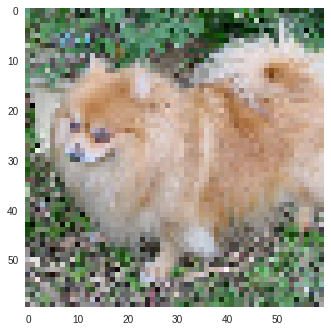


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


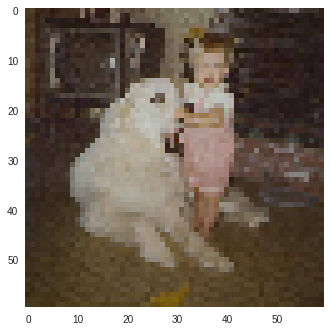


Expected : samoyed
Actual : samoyed
Correct Prediction


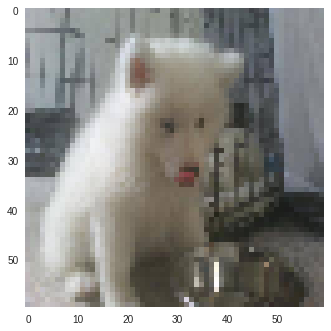


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


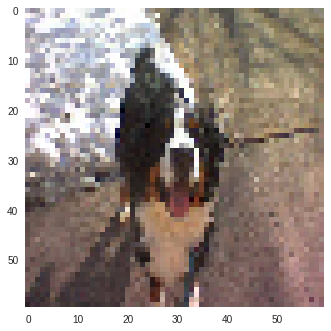


Expected : pomeranian
Actual : shih-tzu
Incorrect Prediction


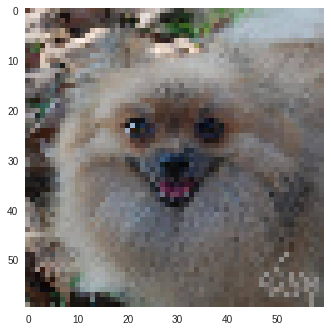


Expected : shih-tzu
Actual : bernese_mountain_dog
Incorrect Prediction


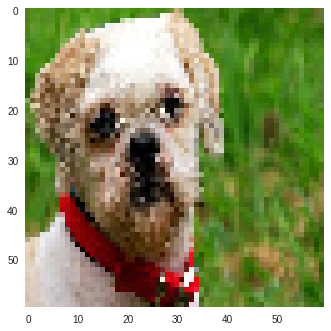


Expected : basenji
Actual : basenji
Correct Prediction


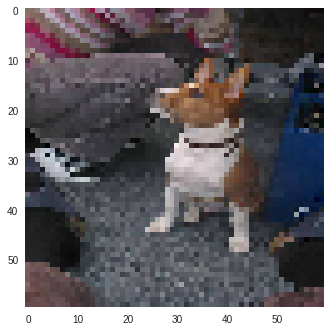


Expected : basenji
Actual : pomeranian
Incorrect Prediction


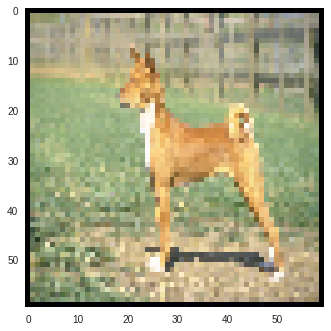


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


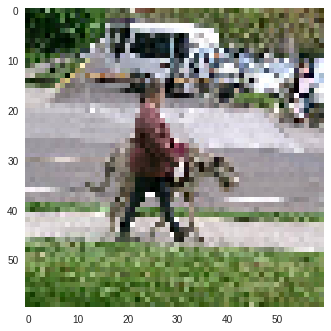


Expected : samoyed
Actual : samoyed
Correct Prediction


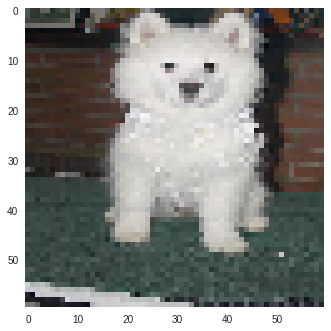


Expected : basenji
Actual : bernese_mountain_dog
Incorrect Prediction


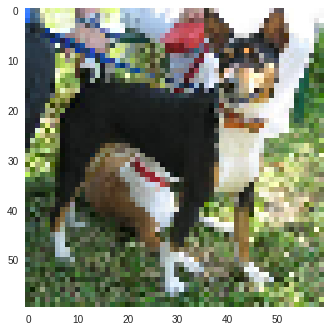


Expected : afghan_hound
Actual : samoyed
Incorrect Prediction


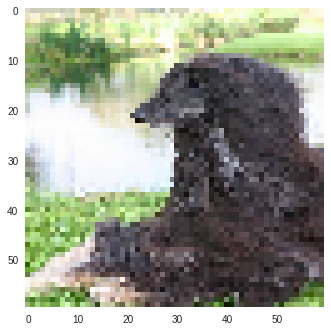


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


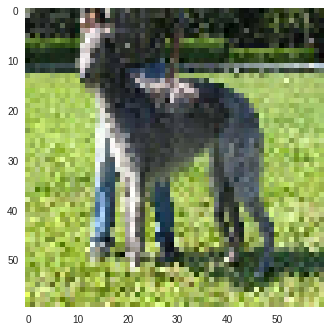


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


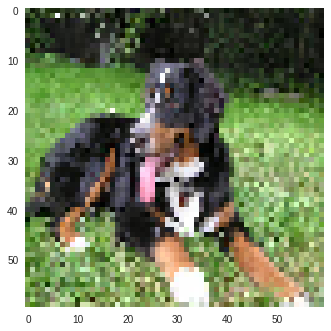


Expected : basenji
Actual : entlebucher
Incorrect Prediction


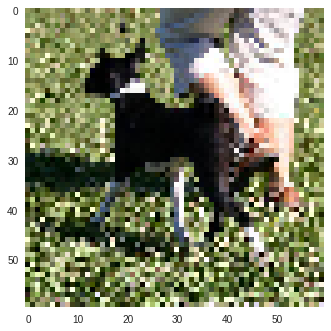


Expected : scottish_deerhound
Actual : pomeranian
Incorrect Prediction


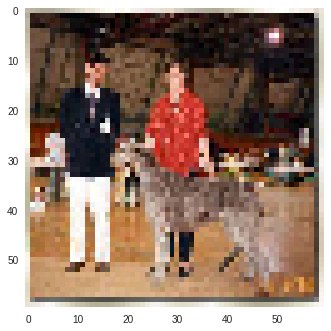


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


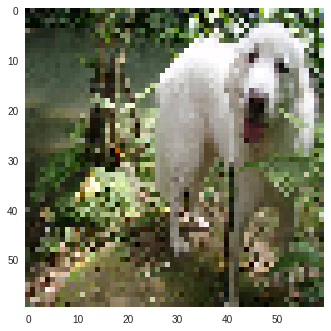


Expected : entlebucher
Actual : entlebucher
Correct Prediction


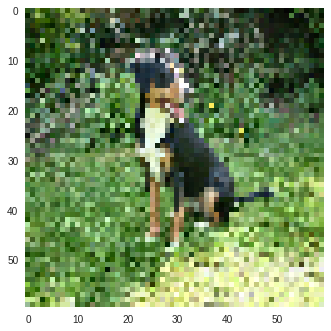


Expected : entlebucher
Actual : entlebucher
Correct Prediction


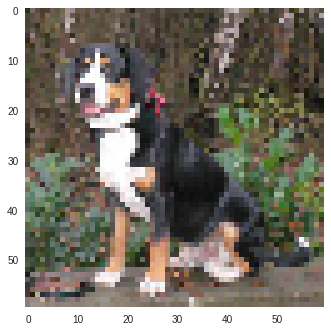


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


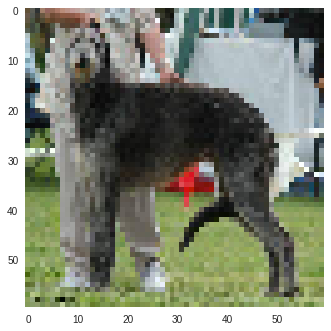


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


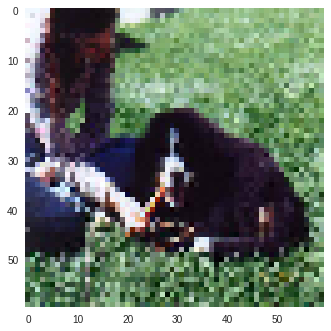


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


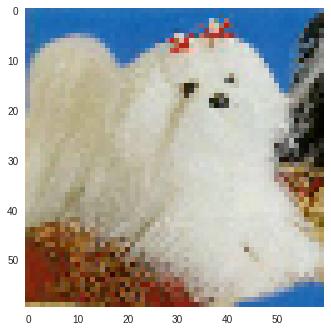


Expected : samoyed
Actual : afghan_hound
Incorrect Prediction


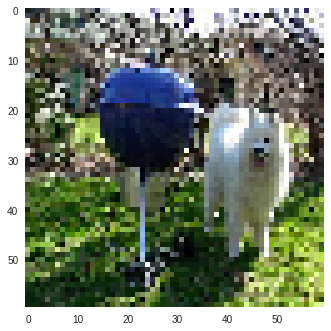


Expected : basenji
Actual : pomeranian
Incorrect Prediction


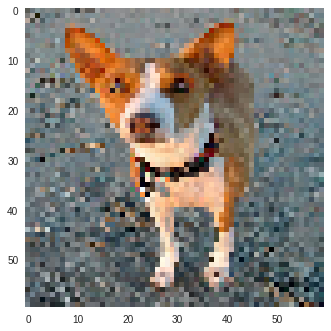


Expected : shih-tzu
Actual : bernese_mountain_dog
Incorrect Prediction


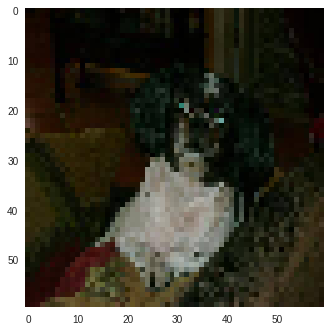


Expected : entlebucher
Actual : maltese_dog
Incorrect Prediction


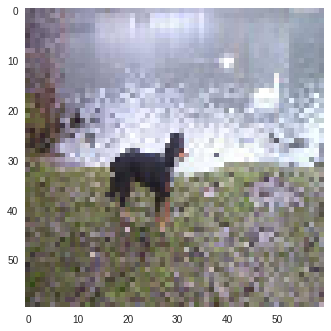


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


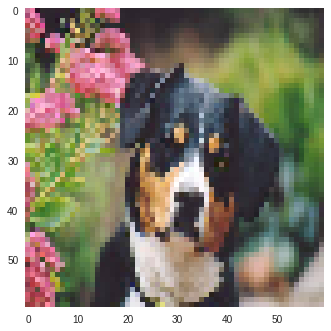


Expected : entlebucher
Actual : afghan_hound
Incorrect Prediction


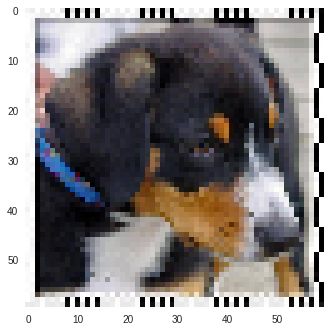


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


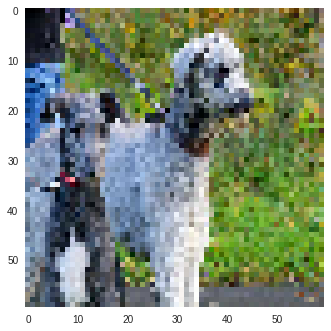


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


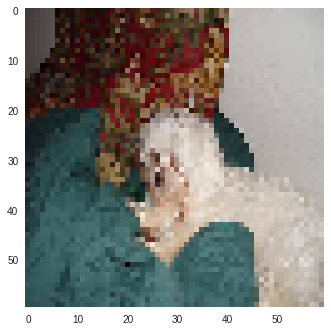


Expected : basenji
Actual : entlebucher
Incorrect Prediction


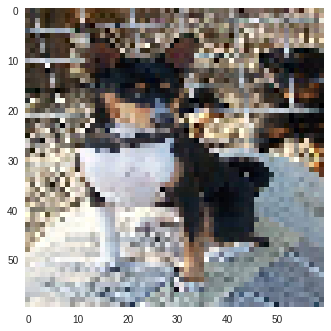


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


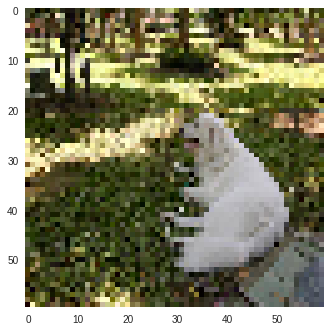


Expected : pomeranian
Actual : pomeranian
Correct Prediction


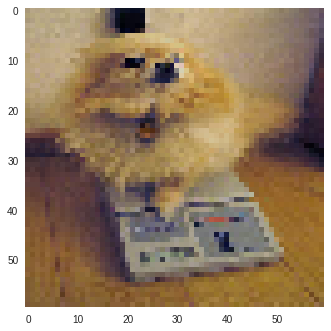


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


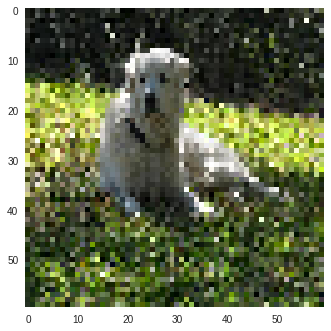


Expected : entlebucher
Actual : entlebucher
Correct Prediction


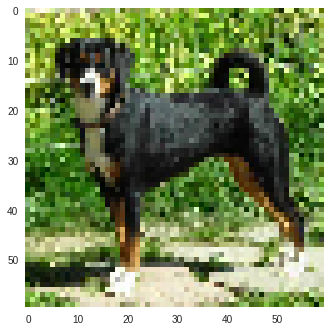


Expected : shih-tzu
Actual : entlebucher
Incorrect Prediction


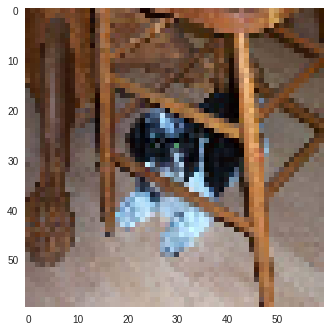


Expected : great_pyrenees
Actual : scottish_deerhound
Incorrect Prediction


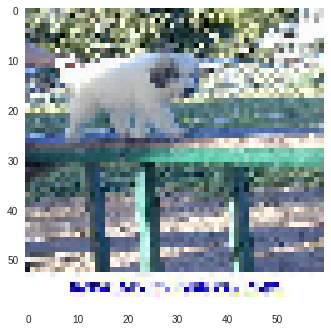


Expected : scottish_deerhound
Actual : shih-tzu
Incorrect Prediction


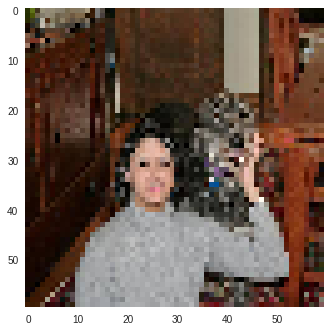


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


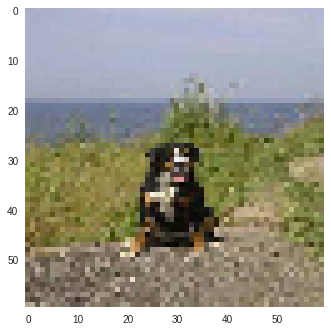


Expected : shih-tzu
Actual : basenji
Incorrect Prediction


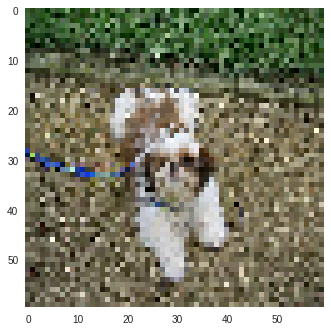


Expected : basenji
Actual : basenji
Correct Prediction


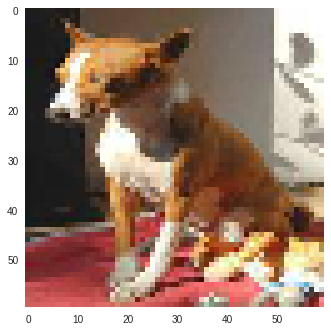


Expected : afghan_hound
Actual : pomeranian
Incorrect Prediction


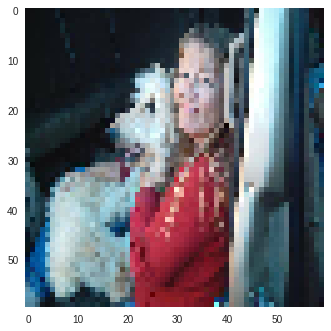


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


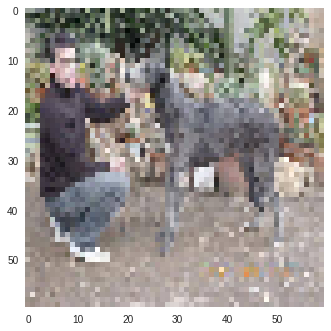


Expected : maltese_dog
Actual : scottish_deerhound
Incorrect Prediction


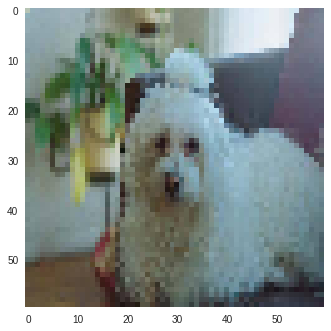


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


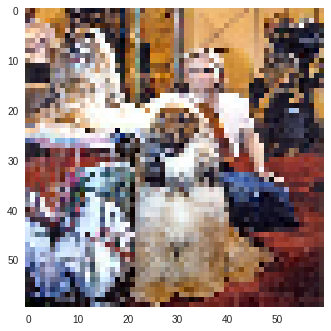


Expected : pomeranian
Actual : pomeranian
Correct Prediction


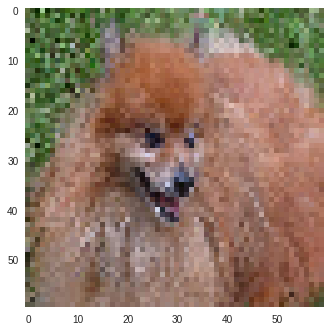


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


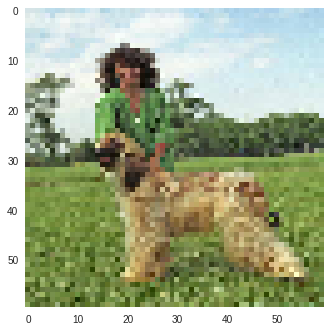


Expected : scottish_deerhound
Actual : entlebucher
Incorrect Prediction


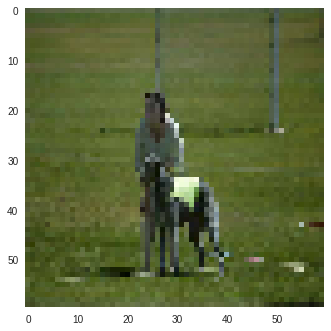


Expected : basenji
Actual : basenji
Correct Prediction


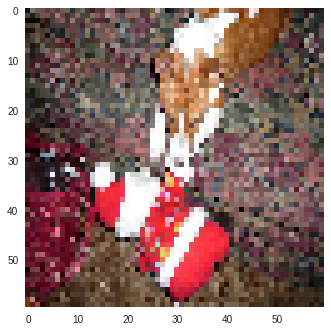


Expected : afghan_hound
Actual : entlebucher
Incorrect Prediction


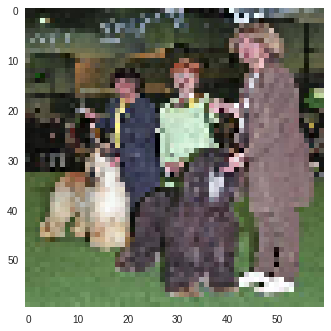


Expected : entlebucher
Actual : entlebucher
Correct Prediction


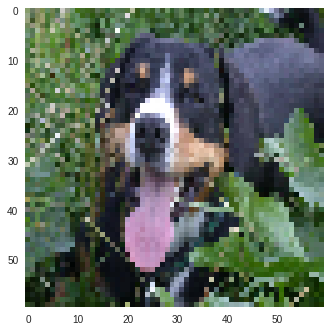


Expected : pomeranian
Actual : pomeranian
Correct Prediction


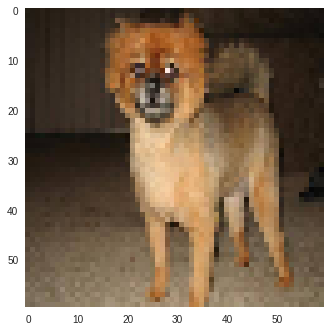


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


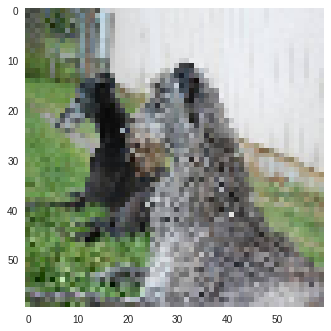


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


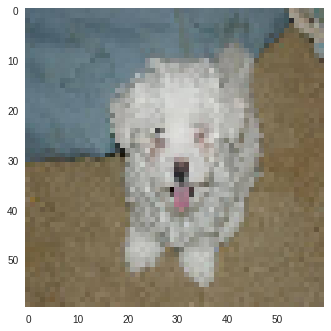


Expected : pomeranian
Actual : basenji
Incorrect Prediction


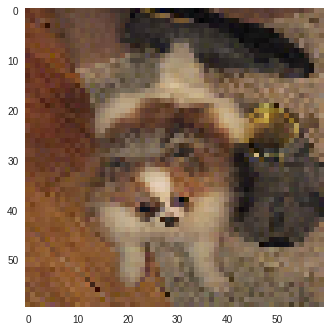


Expected : pomeranian
Actual : afghan_hound
Incorrect Prediction


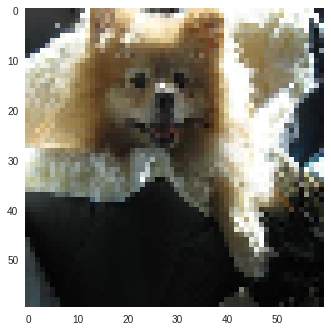


Expected : samoyed
Actual : great_pyrenees
Incorrect Prediction


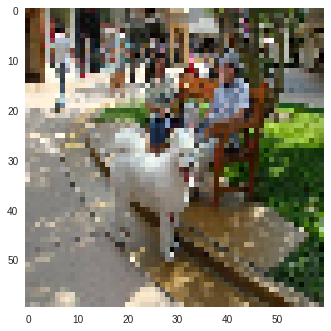


Expected : pomeranian
Actual : maltese_dog
Incorrect Prediction


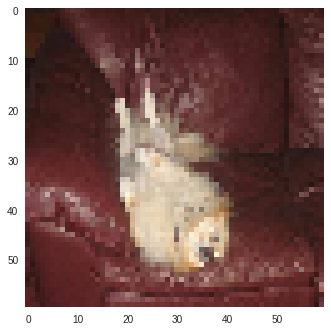


Expected : entlebucher
Actual : basenji
Incorrect Prediction


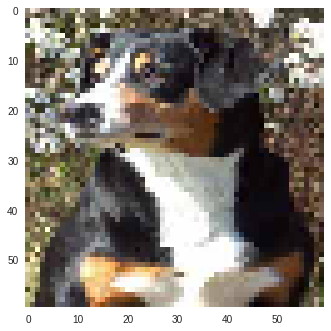


Expected : shih-tzu
Actual : shih-tzu
Correct Prediction


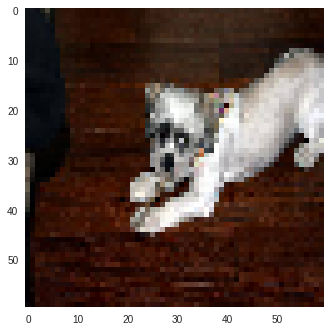


Expected : shih-tzu
Actual : basenji
Incorrect Prediction


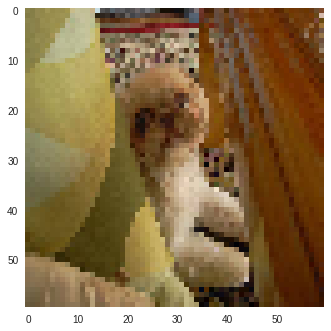


Expected : pomeranian
Actual : pomeranian
Correct Prediction


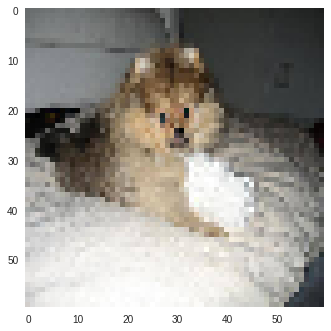


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


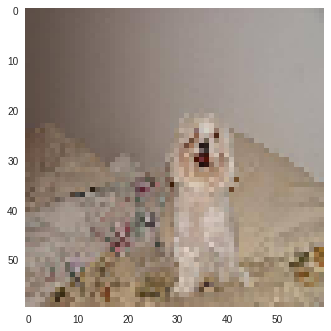


Expected : shih-tzu
Actual : maltese_dog
Incorrect Prediction


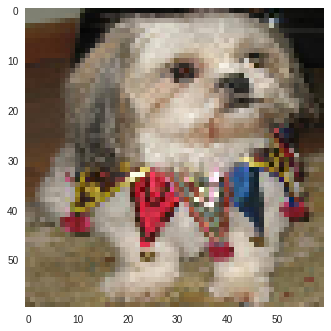


Expected : pomeranian
Actual : basenji
Incorrect Prediction


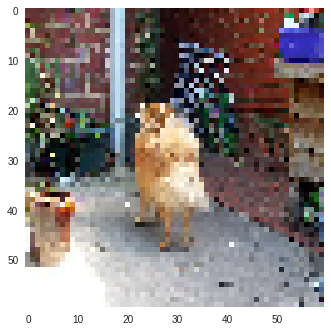


Expected : scottish_deerhound
Actual : basenji
Incorrect Prediction


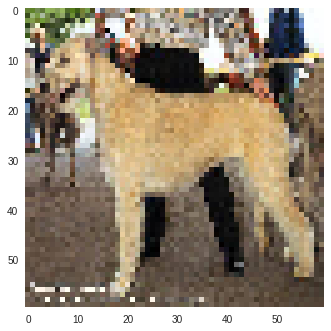


Expected : pomeranian
Actual : basenji
Incorrect Prediction


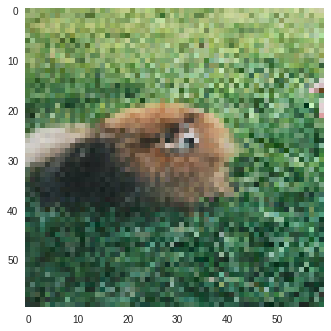


Expected : samoyed
Actual : samoyed
Correct Prediction


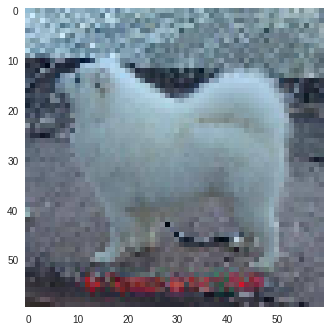


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


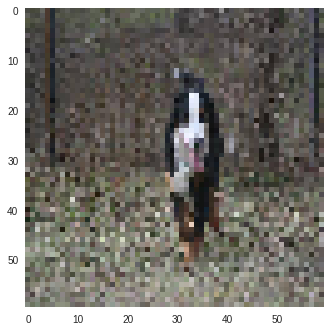


Expected : pomeranian
Actual : basenji
Incorrect Prediction


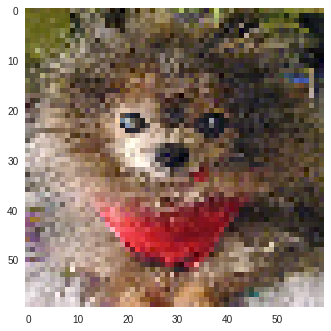


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


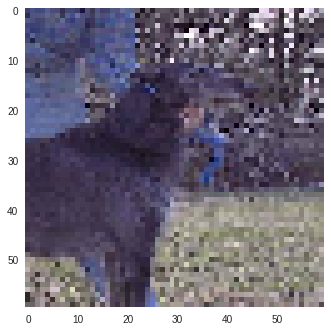


Expected : basenji
Actual : pomeranian
Incorrect Prediction


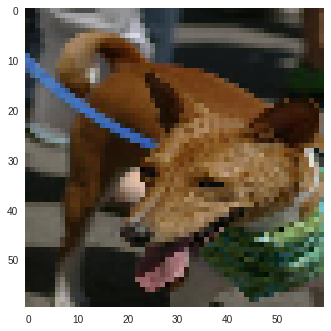


Expected : entlebucher
Actual : entlebucher
Correct Prediction


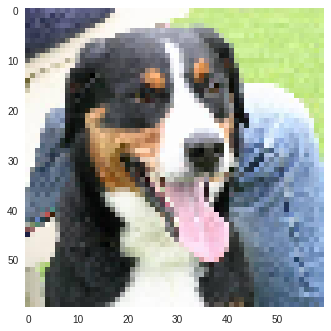


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


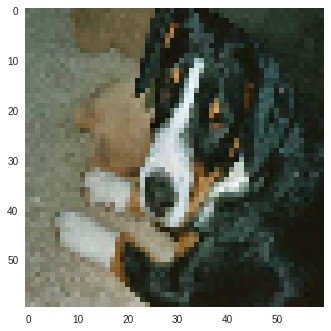


Expected : samoyed
Actual : great_pyrenees
Incorrect Prediction


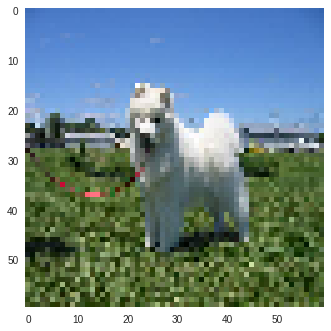


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


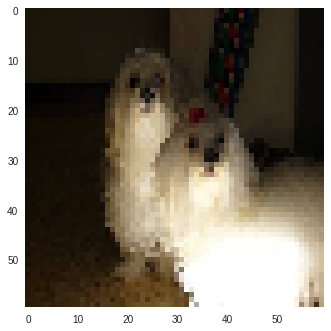


Expected : bernese_mountain_dog
Actual : scottish_deerhound
Incorrect Prediction


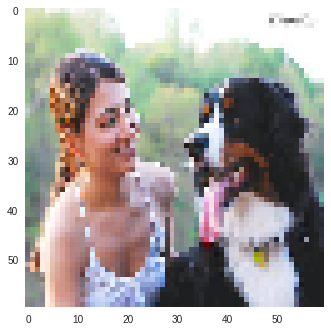


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


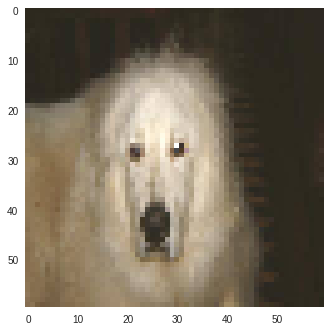


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


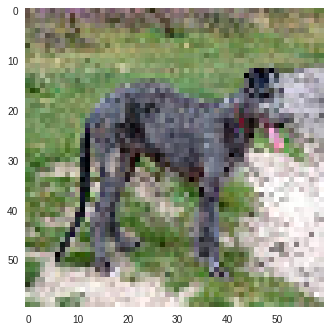


Expected : shih-tzu
Actual : entlebucher
Incorrect Prediction


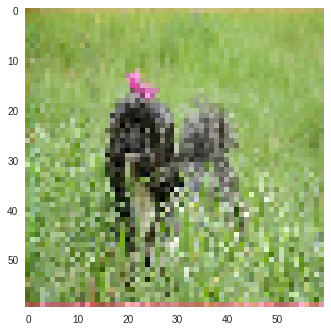


Expected : great_pyrenees
Actual : shih-tzu
Incorrect Prediction


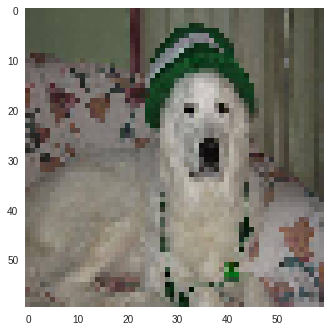


Expected : pomeranian
Actual : samoyed
Incorrect Prediction


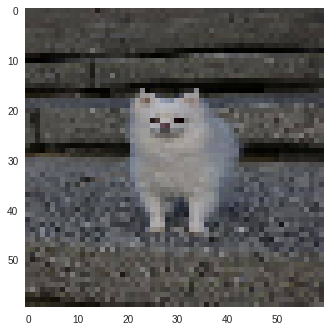


Expected : shih-tzu
Actual : samoyed
Incorrect Prediction


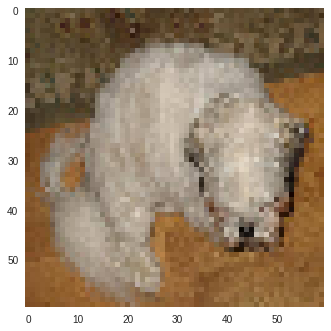


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


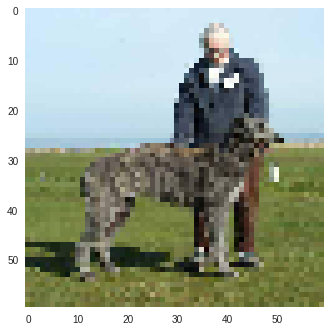


Expected : samoyed
Actual : scottish_deerhound
Incorrect Prediction


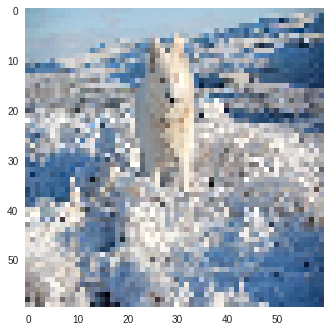


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


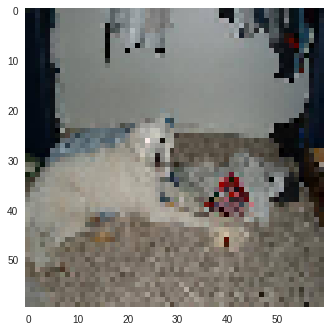


Expected : great_pyrenees
Actual : basenji
Incorrect Prediction


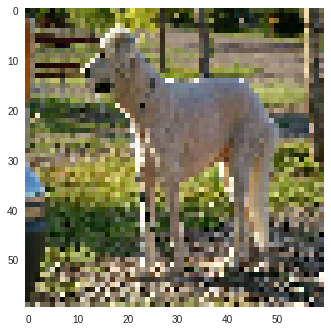


Expected : shih-tzu
Actual : shih-tzu
Correct Prediction


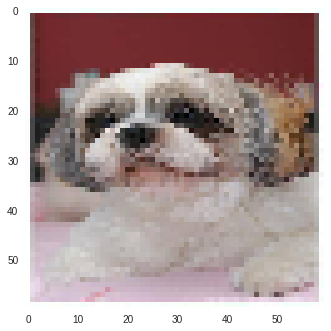


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


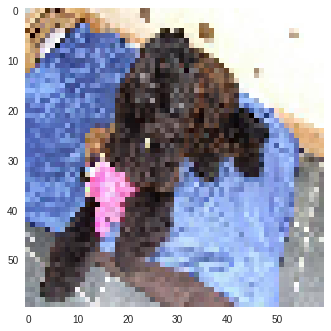


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


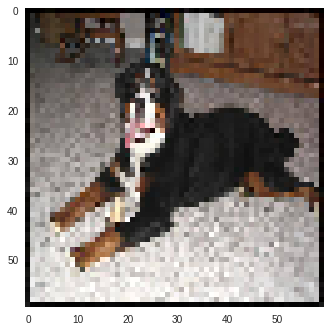


Expected : shih-tzu
Actual : entlebucher
Incorrect Prediction


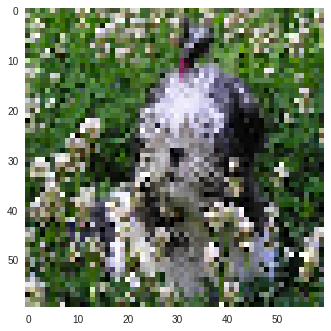


Expected : shih-tzu
Actual : scottish_deerhound
Incorrect Prediction


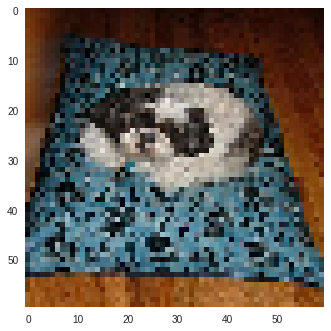


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


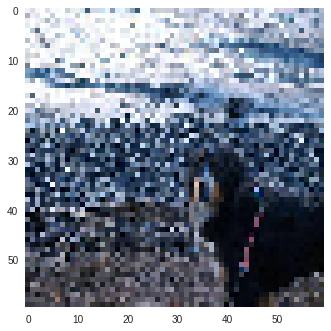


Expected : afghan_hound
Actual : basenji
Incorrect Prediction


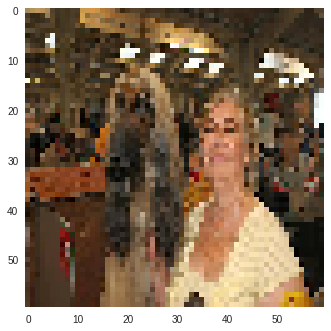


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


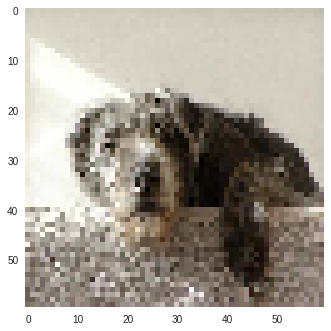


Expected : bernese_mountain_dog
Actual : basenji
Incorrect Prediction


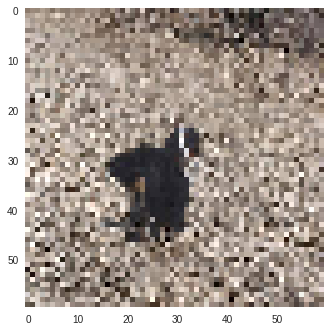


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


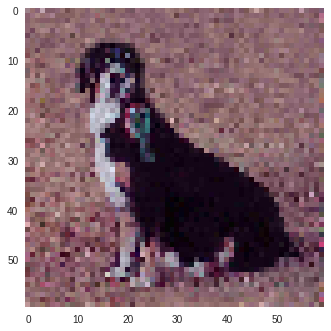


Expected : scottish_deerhound
Actual : entlebucher
Incorrect Prediction


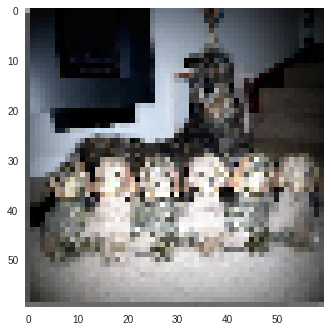


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


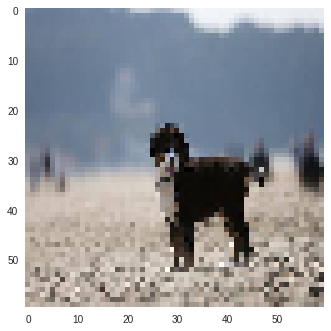


Expected : pomeranian
Actual : basenji
Incorrect Prediction


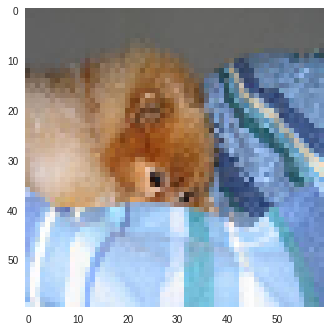


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


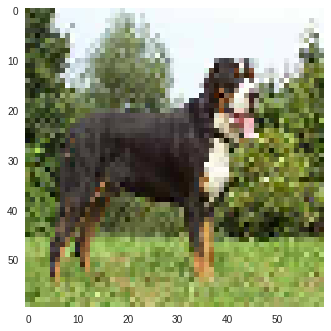


Expected : shih-tzu
Actual : entlebucher
Incorrect Prediction


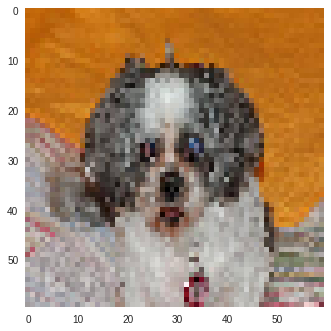


Expected : entlebucher
Actual : entlebucher
Correct Prediction


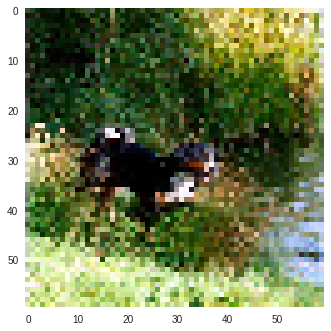


Expected : scottish_deerhound
Actual : great_pyrenees
Incorrect Prediction


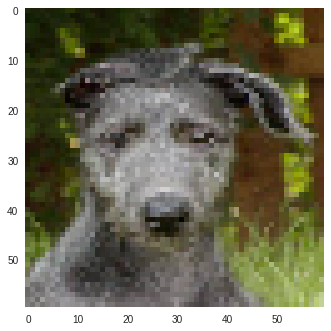


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


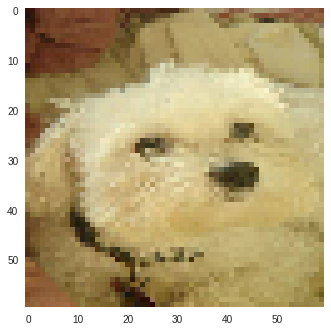


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


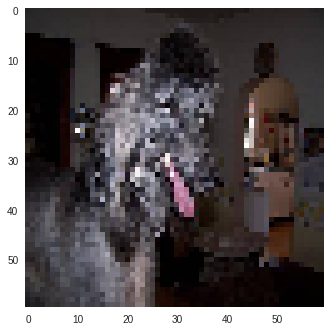


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


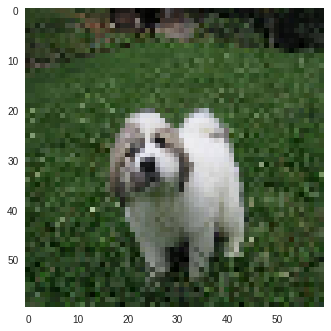


Expected : shih-tzu
Actual : shih-tzu
Correct Prediction


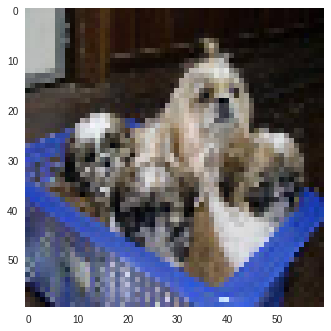


Expected : basenji
Actual : scottish_deerhound
Incorrect Prediction


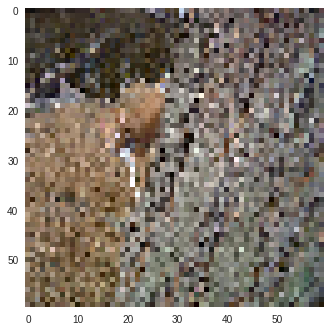


Expected : great_pyrenees
Actual : scottish_deerhound
Incorrect Prediction


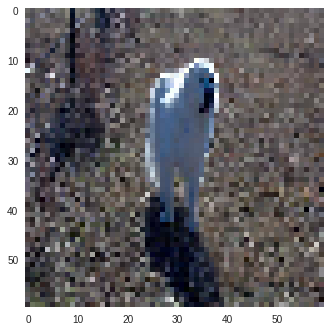


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


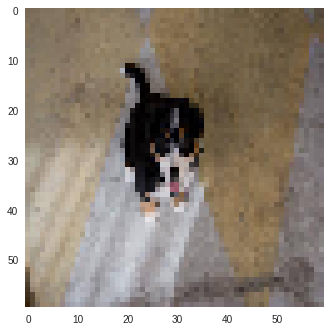


Expected : entlebucher
Actual : basenji
Incorrect Prediction


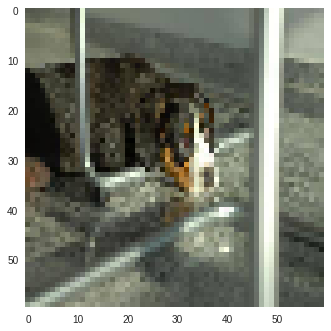


Expected : samoyed
Actual : samoyed
Correct Prediction


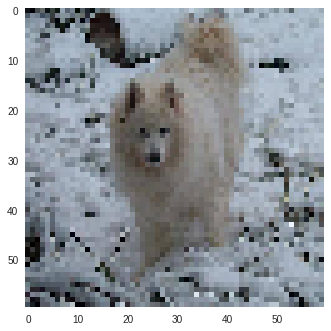


Expected : great_pyrenees
Actual : entlebucher
Incorrect Prediction


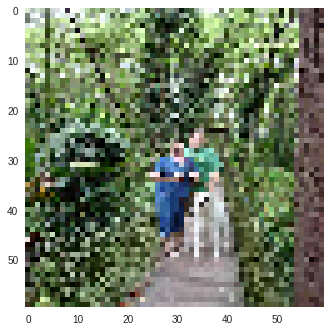


Expected : entlebucher
Actual : entlebucher
Correct Prediction


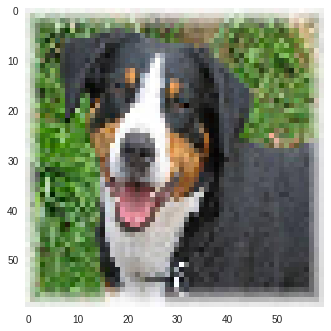


Expected : bernese_mountain_dog
Actual : scottish_deerhound
Incorrect Prediction


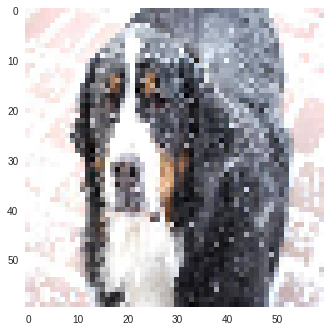


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


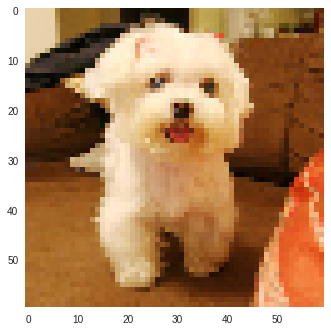


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


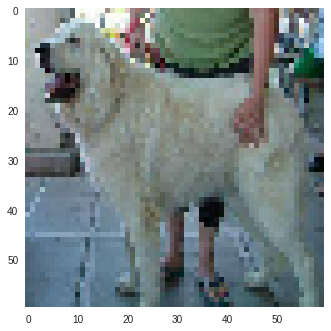


Expected : great_pyrenees
Actual : shih-tzu
Incorrect Prediction


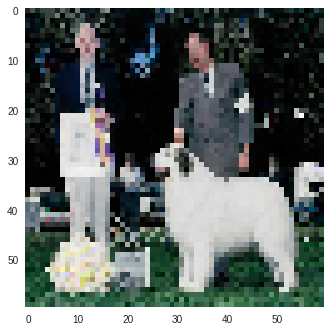


Expected : entlebucher
Actual : basenji
Incorrect Prediction


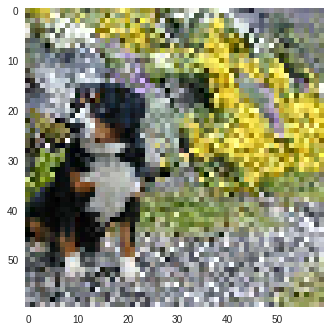


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


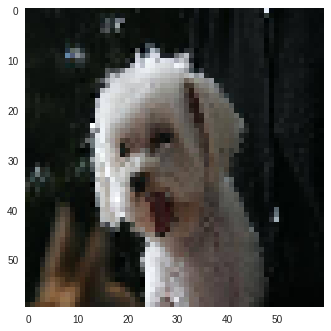


Expected : pomeranian
Actual : basenji
Incorrect Prediction


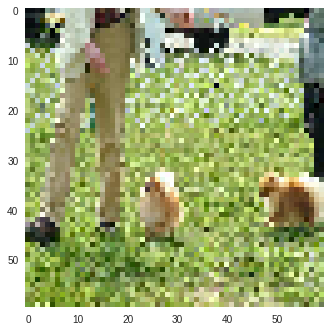


Expected : scottish_deerhound
Actual : entlebucher
Incorrect Prediction


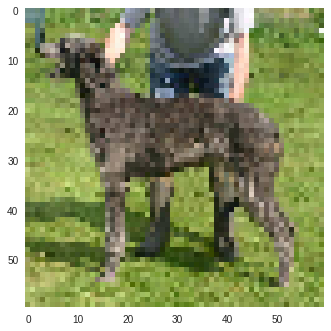


Expected : shih-tzu
Actual : samoyed
Incorrect Prediction


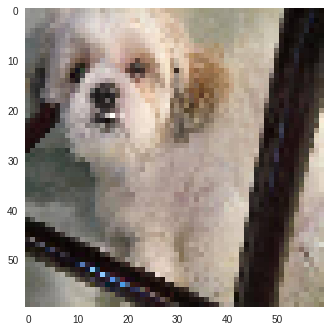


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


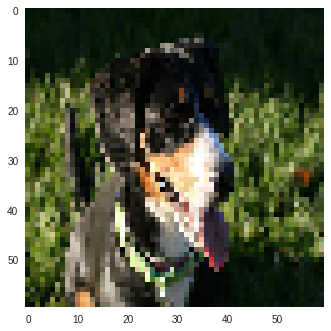


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


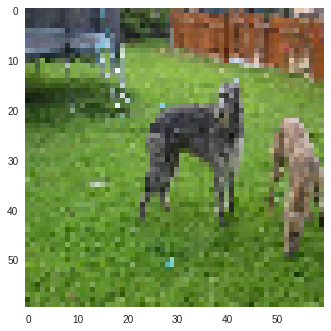


Expected : entlebucher
Actual : shih-tzu
Incorrect Prediction


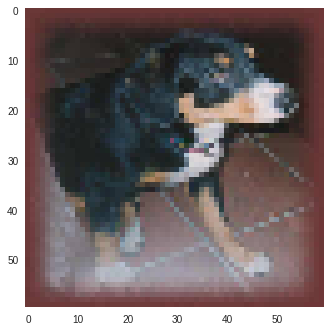


Expected : samoyed
Actual : maltese_dog
Incorrect Prediction


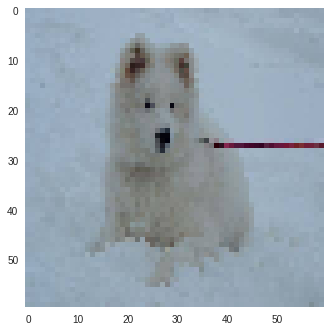


Expected : entlebucher
Actual : entlebucher
Correct Prediction


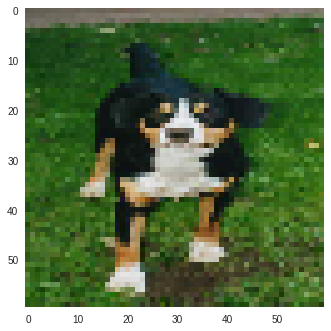


Expected : pomeranian
Actual : pomeranian
Correct Prediction


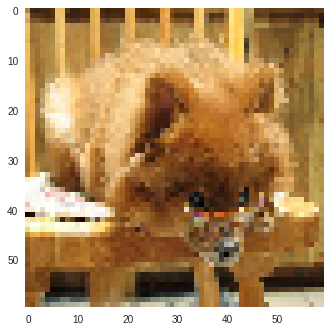


Expected : entlebucher
Actual : basenji
Incorrect Prediction


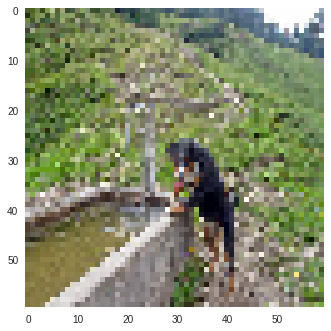


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


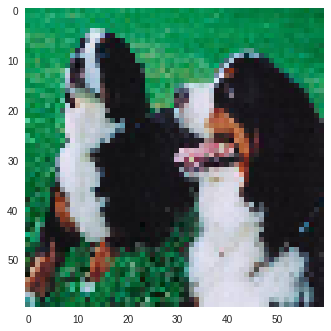


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


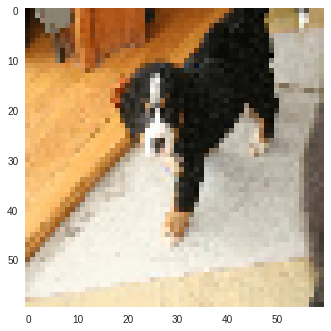


Expected : great_pyrenees
Actual : entlebucher
Incorrect Prediction


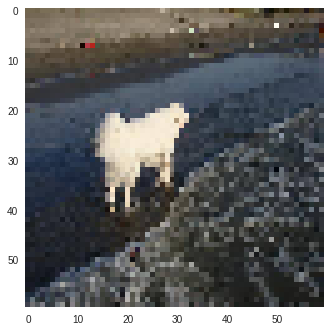


Expected : scottish_deerhound
Actual : afghan_hound
Incorrect Prediction


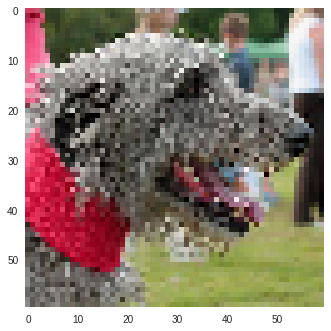


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


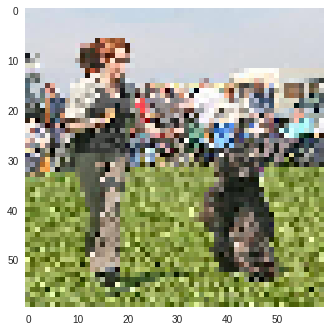


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


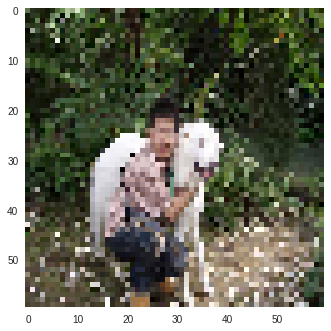


Expected : basenji
Actual : pomeranian
Incorrect Prediction


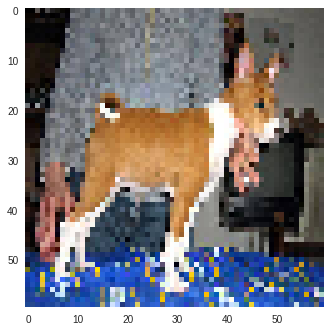


Expected : basenji
Actual : great_pyrenees
Incorrect Prediction


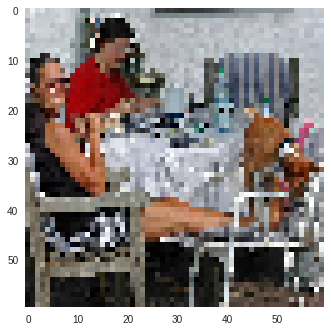


Expected : samoyed
Actual : samoyed
Correct Prediction


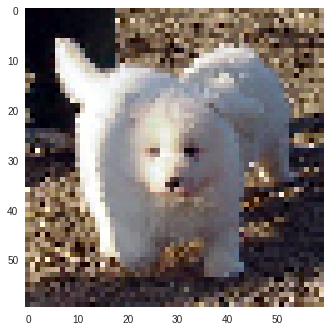


Expected : pomeranian
Actual : pomeranian
Correct Prediction


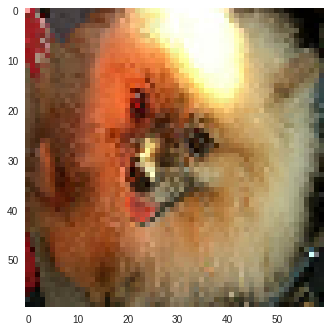


Expected : maltese_dog
Actual : great_pyrenees
Incorrect Prediction


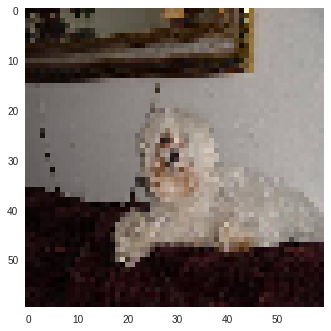


Expected : basenji
Actual : basenji
Correct Prediction


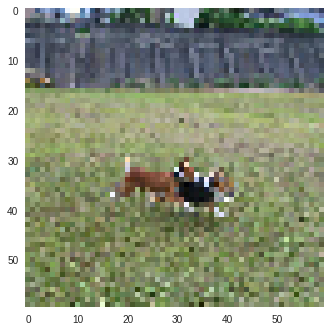


Expected : basenji
Actual : pomeranian
Incorrect Prediction


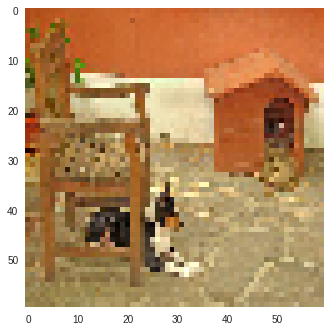


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


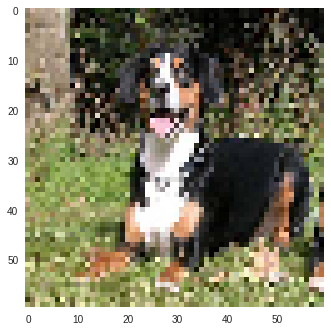


Expected : samoyed
Actual : samoyed
Correct Prediction


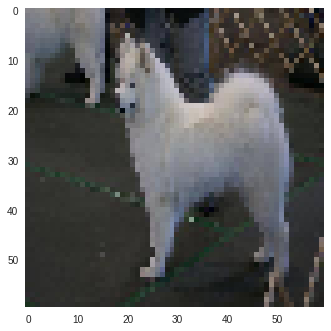


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


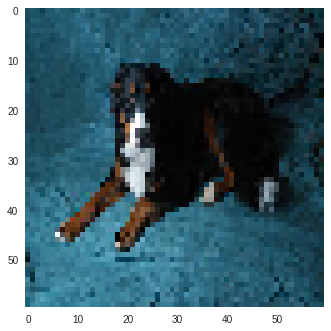


Expected : shih-tzu
Actual : great_pyrenees
Incorrect Prediction


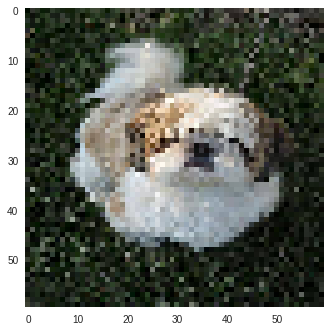


Expected : pomeranian
Actual : shih-tzu
Incorrect Prediction


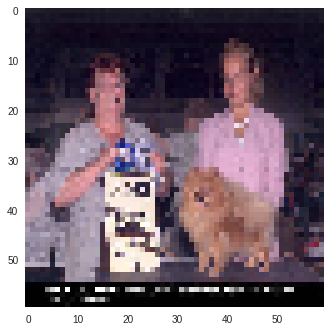


Expected : afghan_hound
Actual : entlebucher
Incorrect Prediction


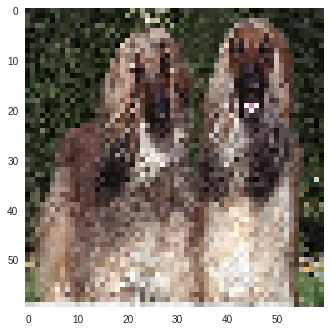


Expected : samoyed
Actual : shih-tzu
Incorrect Prediction


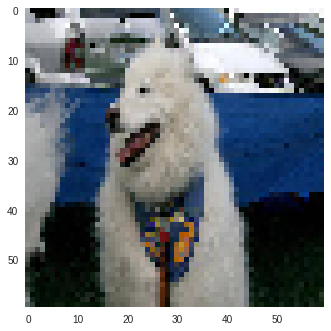


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


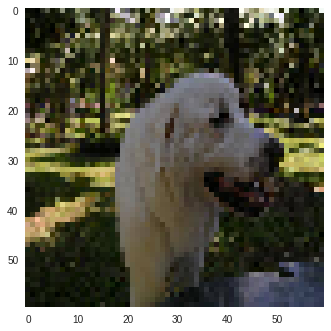


Expected : afghan_hound
Actual : afghan_hound
Correct Prediction


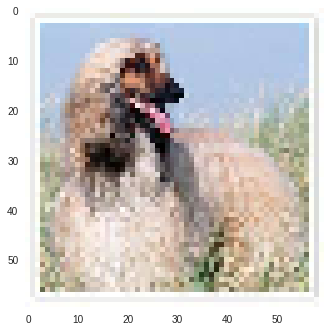


Expected : entlebucher
Actual : shih-tzu
Incorrect Prediction


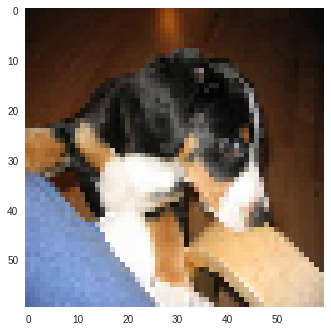


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


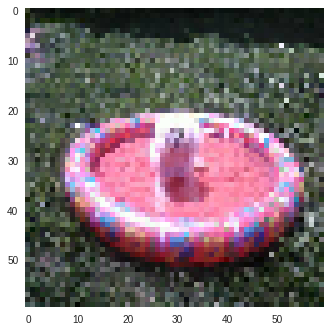


Expected : pomeranian
Actual : pomeranian
Correct Prediction


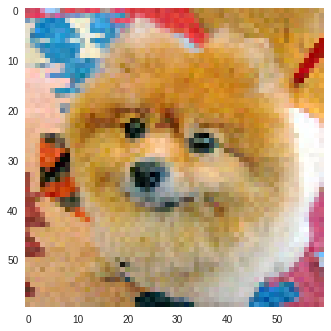


Expected : afghan_hound
Actual : great_pyrenees
Incorrect Prediction


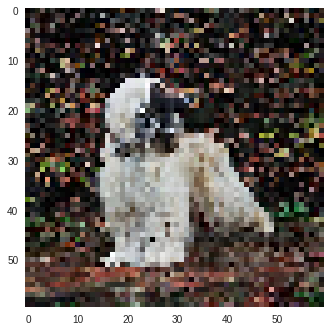


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


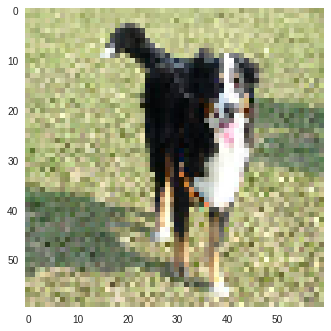


Expected : bernese_mountain_dog
Actual : shih-tzu
Incorrect Prediction


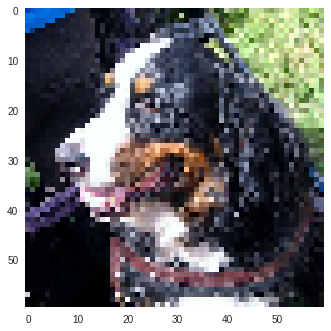


Expected : entlebucher
Actual : shih-tzu
Incorrect Prediction


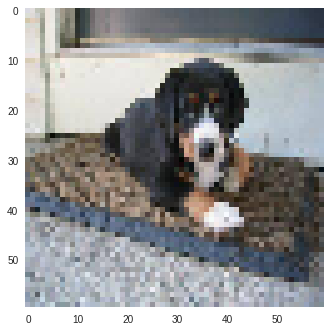


Expected : basenji
Actual : bernese_mountain_dog
Incorrect Prediction


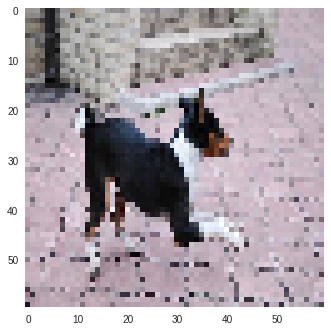


Expected : great_pyrenees
Actual : scottish_deerhound
Incorrect Prediction


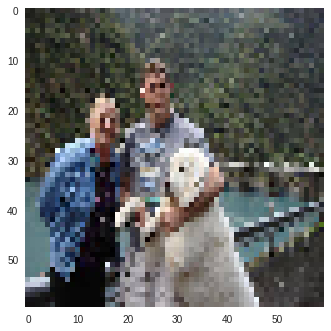


Expected : entlebucher
Actual : entlebucher
Correct Prediction


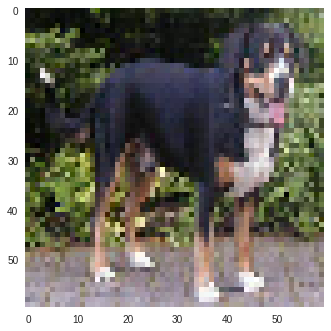


Expected : great_pyrenees
Actual : maltese_dog
Incorrect Prediction


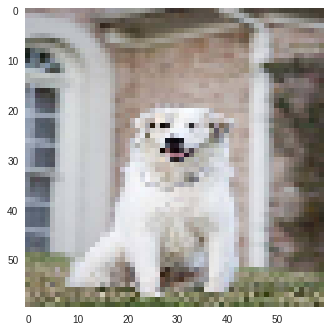


Expected : shih-tzu
Actual : scottish_deerhound
Incorrect Prediction


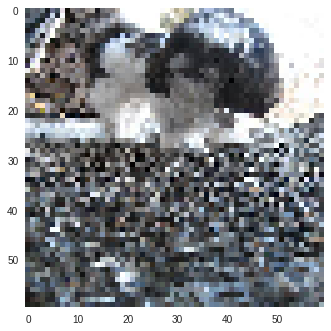


Expected : basenji
Actual : pomeranian
Incorrect Prediction


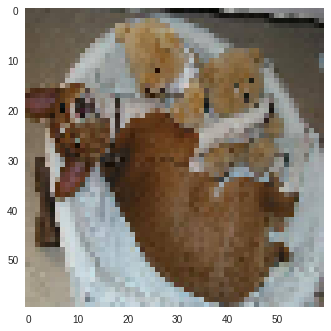


Expected : samoyed
Actual : maltese_dog
Incorrect Prediction


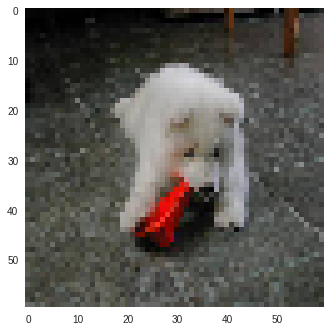


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


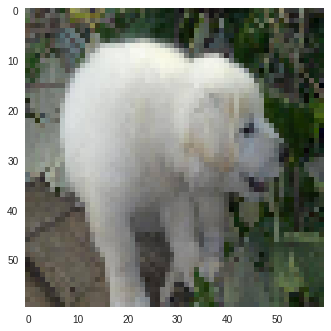


Expected : shih-tzu
Actual : great_pyrenees
Incorrect Prediction


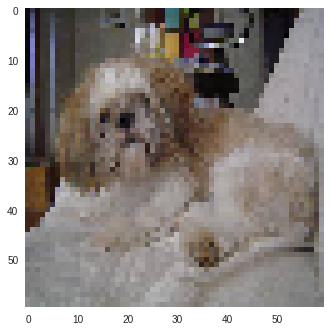


Expected : great_pyrenees
Actual : maltese_dog
Incorrect Prediction


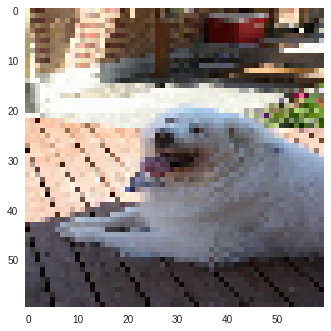


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


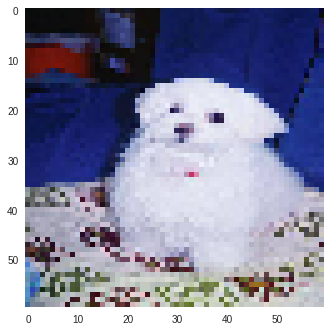


Expected : pomeranian
Actual : pomeranian
Correct Prediction


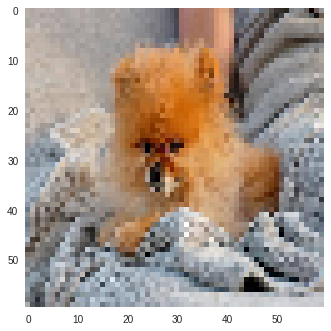


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


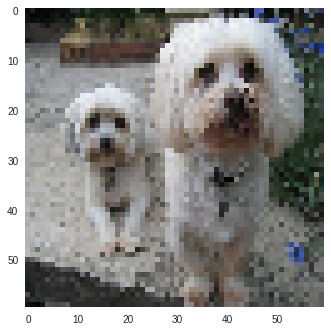


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


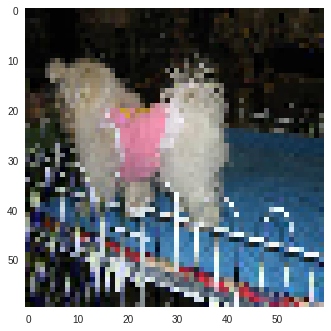


Expected : great_pyrenees
Actual : bernese_mountain_dog
Incorrect Prediction


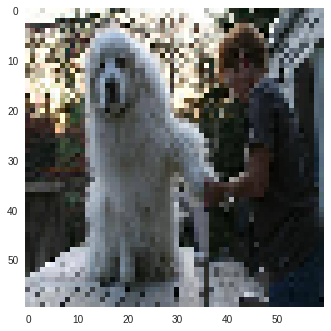


Expected : entlebucher
Actual : entlebucher
Correct Prediction


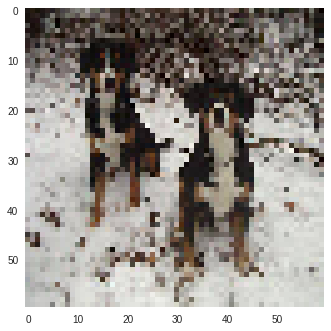


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


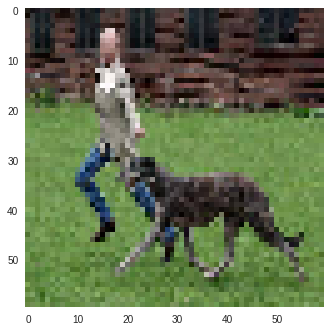


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


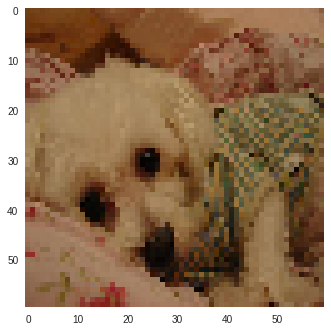


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


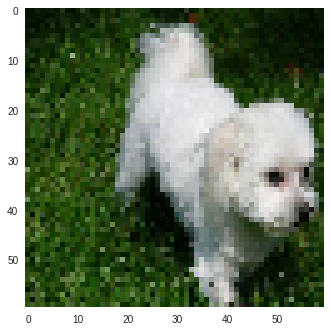


Expected : shih-tzu
Actual : bernese_mountain_dog
Incorrect Prediction


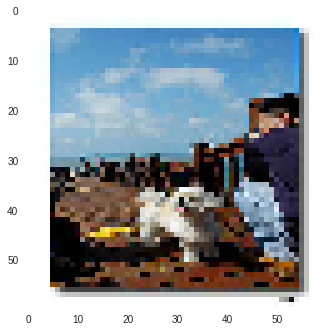


Expected : basenji
Actual : basenji
Correct Prediction


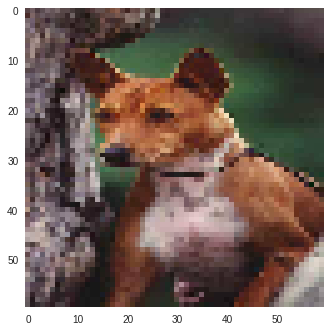


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


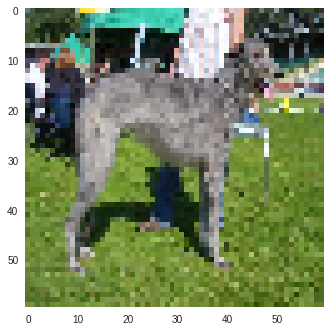


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


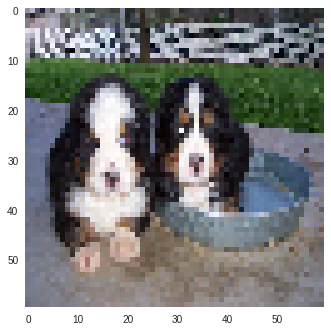


Expected : bernese_mountain_dog
Actual : afghan_hound
Incorrect Prediction


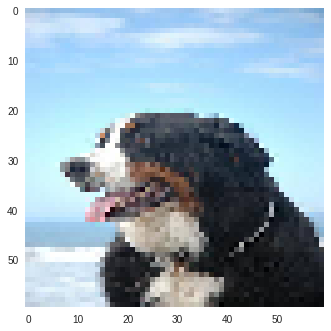


Expected : samoyed
Actual : maltese_dog
Incorrect Prediction


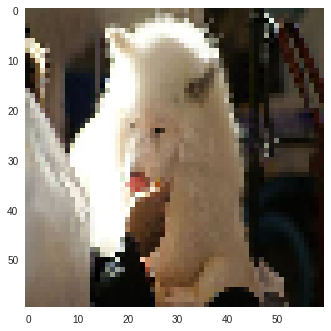


Expected : afghan_hound
Actual : afghan_hound
Correct Prediction


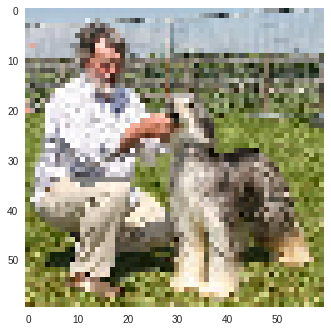


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


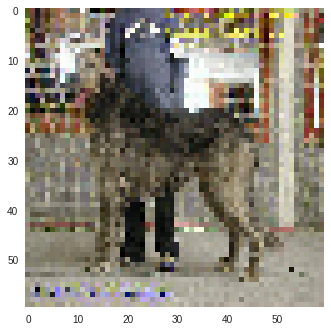


Expected : bernese_mountain_dog
Actual : shih-tzu
Incorrect Prediction


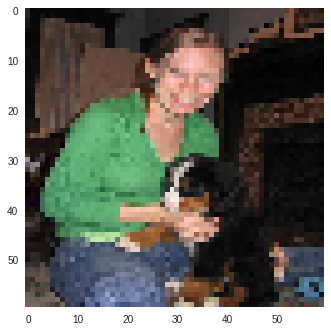


Expected : entlebucher
Actual : entlebucher
Correct Prediction


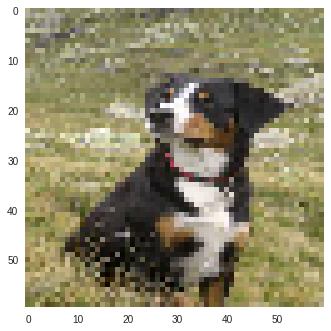


Expected : scottish_deerhound
Actual : samoyed
Incorrect Prediction


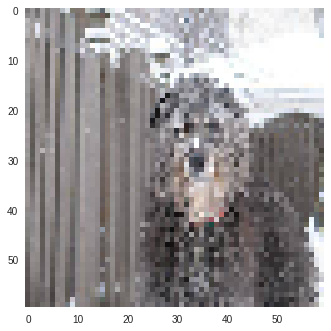


Expected : pomeranian
Actual : scottish_deerhound
Incorrect Prediction


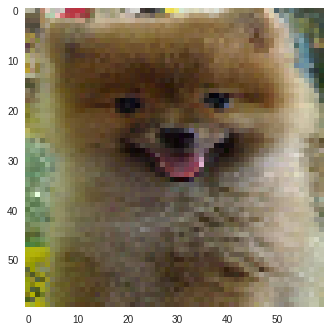


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


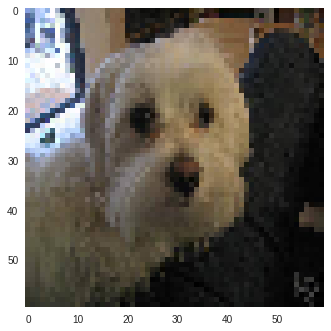


Expected : entlebucher
Actual : basenji
Incorrect Prediction


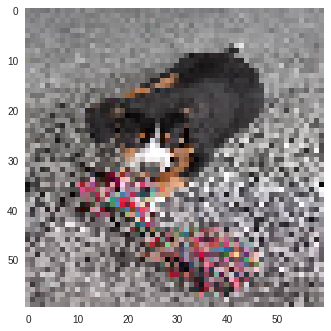


Expected : entlebucher
Actual : entlebucher
Correct Prediction


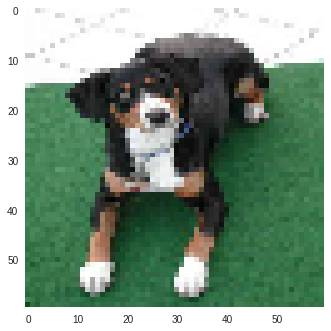


Expected : afghan_hound
Actual : basenji
Incorrect Prediction


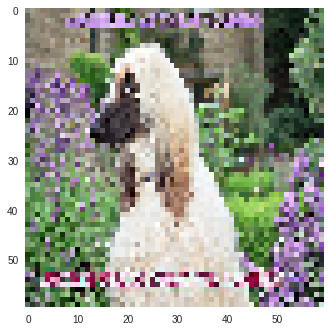


Expected : basenji
Actual : maltese_dog
Incorrect Prediction


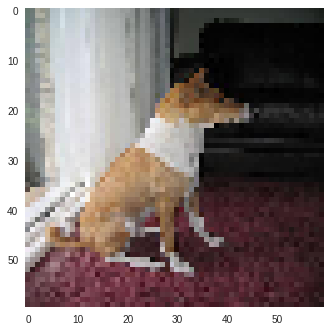


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


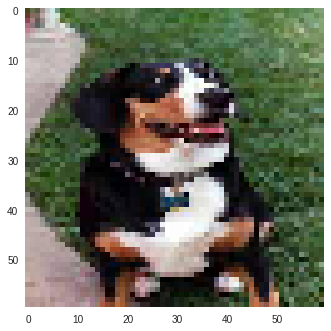


Expected : basenji
Actual : basenji
Correct Prediction


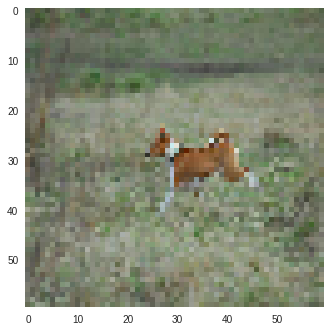


Expected : scottish_deerhound
Actual : shih-tzu
Incorrect Prediction


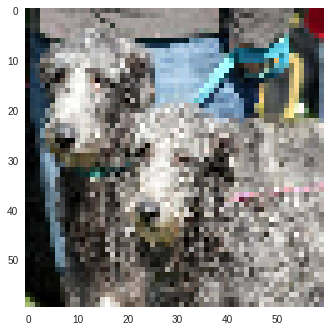


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


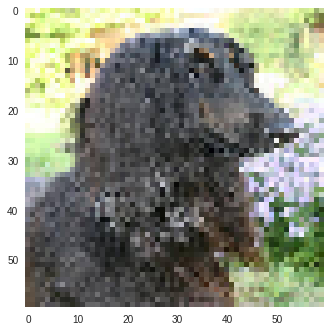


Expected : basenji
Actual : bernese_mountain_dog
Incorrect Prediction


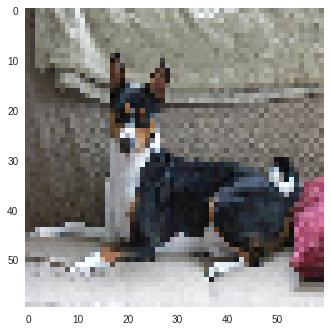


Expected : shih-tzu
Actual : basenji
Incorrect Prediction


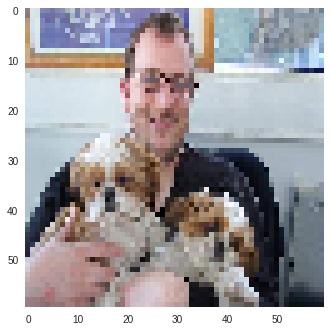


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


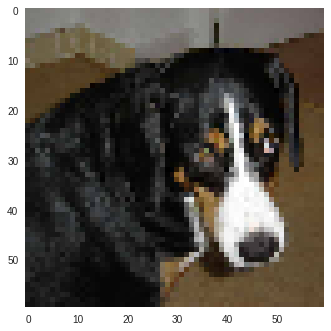


Expected : samoyed
Actual : samoyed
Correct Prediction


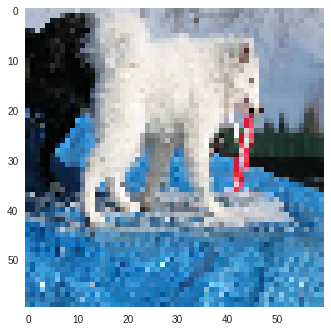


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


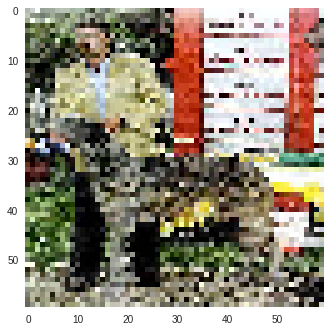


Expected : pomeranian
Actual : afghan_hound
Incorrect Prediction


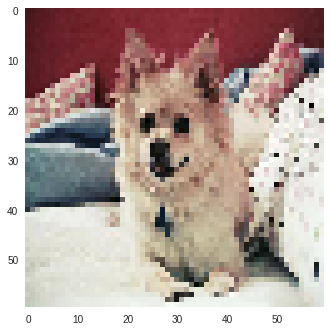


Expected : entlebucher
Actual : basenji
Incorrect Prediction


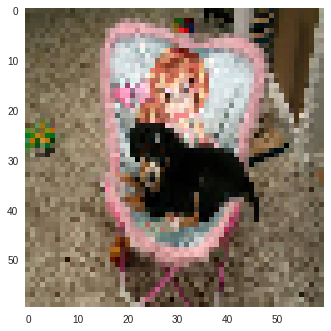


Expected : basenji
Actual : shih-tzu
Incorrect Prediction


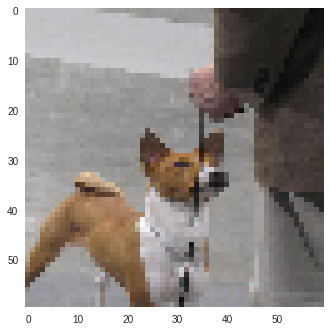


Expected : great_pyrenees
Actual : basenji
Incorrect Prediction


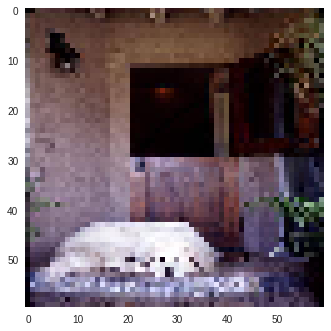


Expected : basenji
Actual : scottish_deerhound
Incorrect Prediction


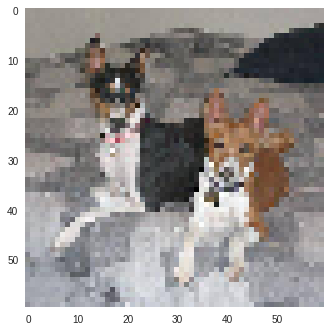


Expected : basenji
Actual : samoyed
Incorrect Prediction


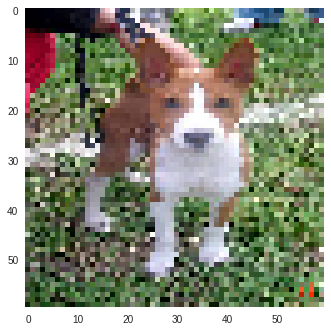


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


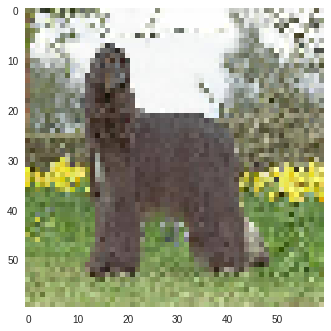


Expected : afghan_hound
Actual : great_pyrenees
Incorrect Prediction


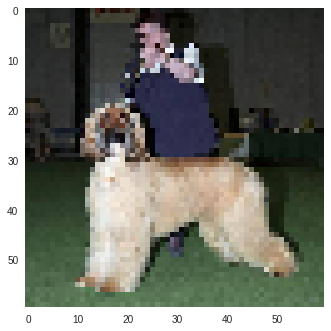


Expected : shih-tzu
Actual : shih-tzu
Correct Prediction


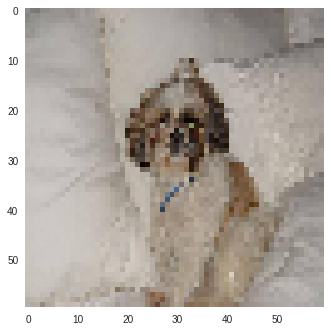


Expected : shih-tzu
Actual : scottish_deerhound
Incorrect Prediction


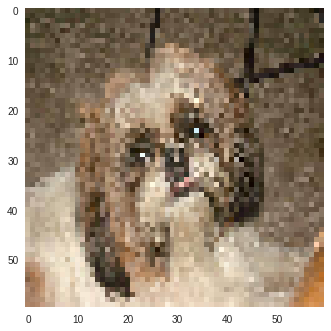


Expected : scottish_deerhound
Actual : great_pyrenees
Incorrect Prediction


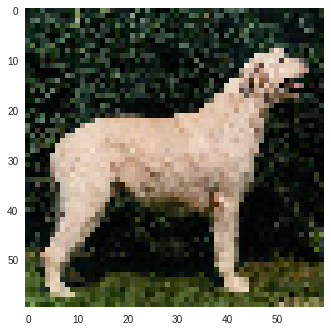


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


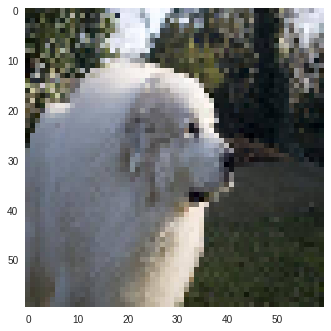


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


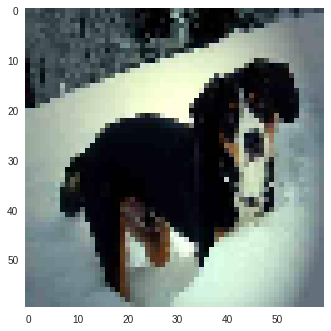


Expected : basenji
Actual : maltese_dog
Incorrect Prediction


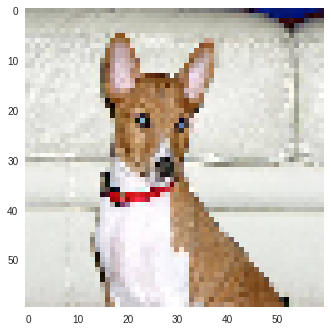


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


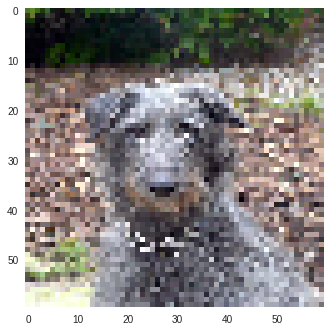


Expected : afghan_hound
Actual : maltese_dog
Incorrect Prediction


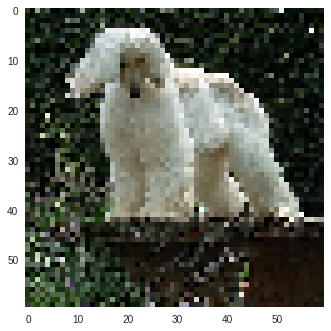


Expected : pomeranian
Actual : pomeranian
Correct Prediction


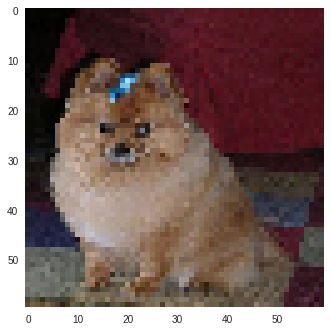


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


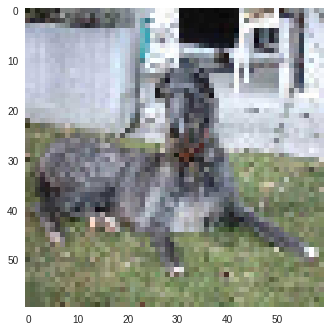


Expected : pomeranian
Actual : pomeranian
Correct Prediction


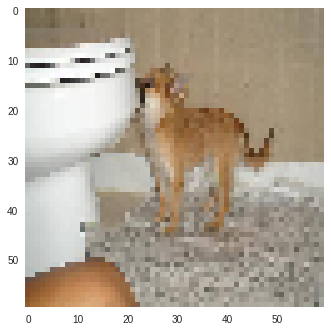


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


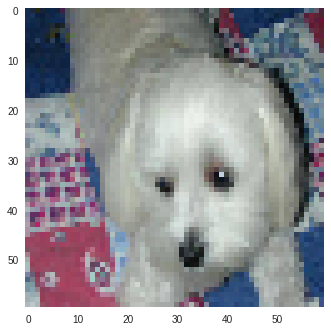


Expected : great_pyrenees
Actual : basenji
Incorrect Prediction


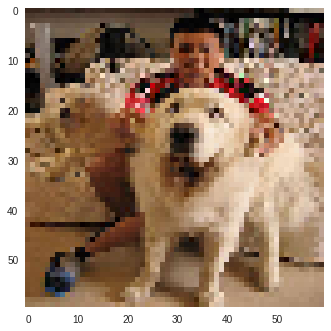


Expected : pomeranian
Actual : shih-tzu
Incorrect Prediction


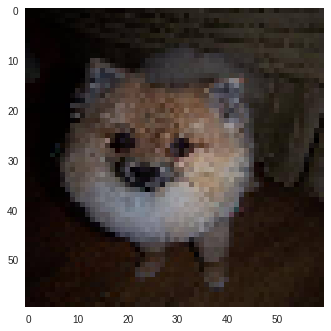


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


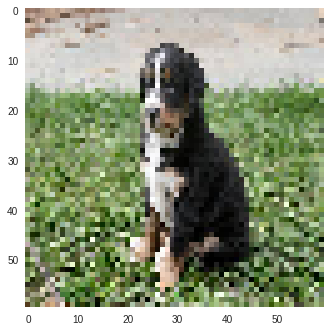


Expected : basenji
Actual : maltese_dog
Incorrect Prediction


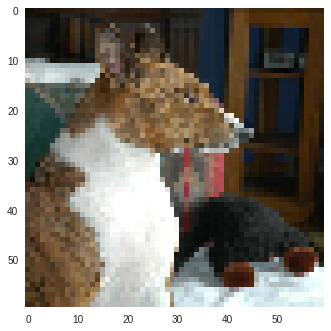


Expected : pomeranian
Actual : great_pyrenees
Incorrect Prediction


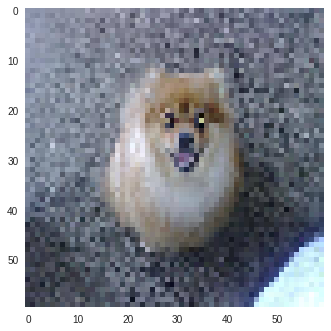


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


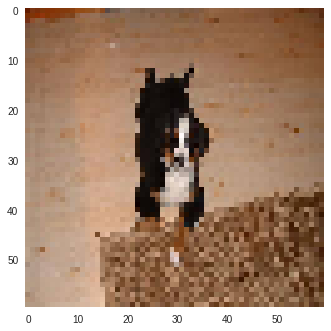


Expected : great_pyrenees
Actual : scottish_deerhound
Incorrect Prediction


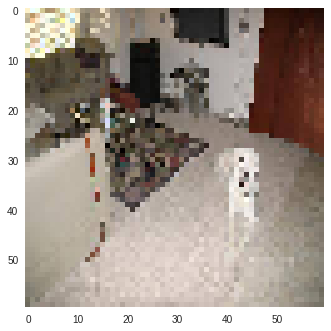


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


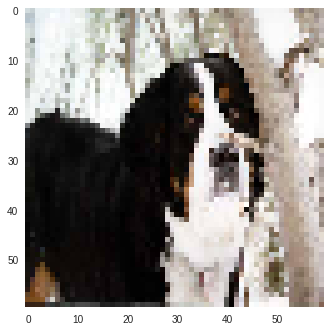


Expected : entlebucher
Actual : entlebucher
Correct Prediction


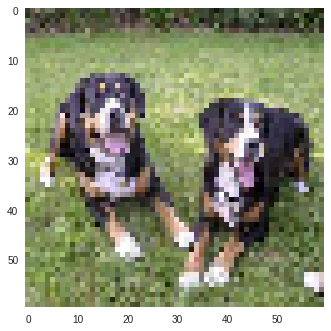


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


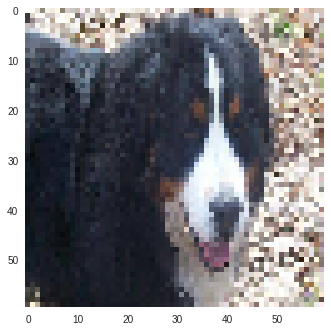


Expected : basenji
Actual : basenji
Correct Prediction


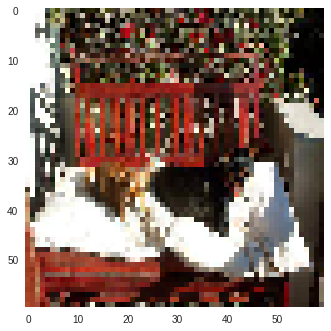


Expected : pomeranian
Actual : pomeranian
Correct Prediction


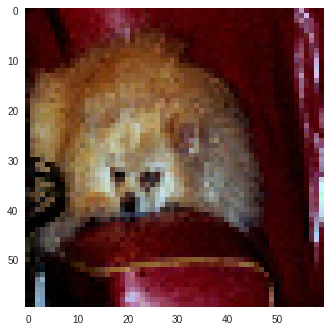


Expected : great_pyrenees
Actual : maltese_dog
Incorrect Prediction


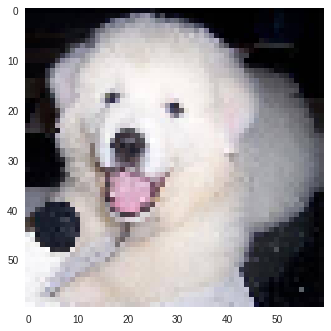


Expected : basenji
Actual : entlebucher
Incorrect Prediction


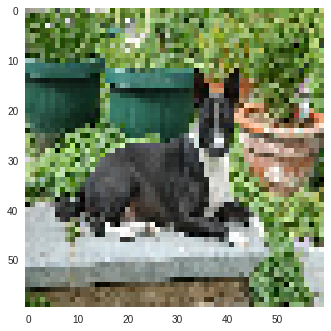


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


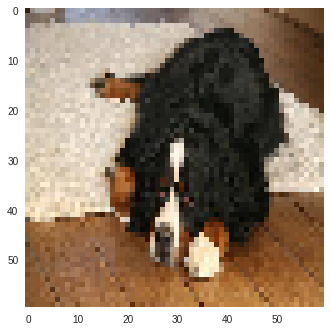


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


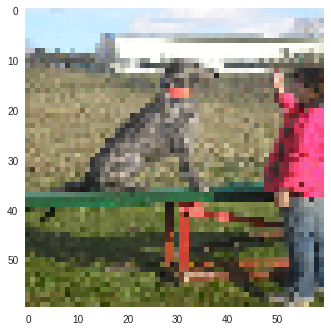


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


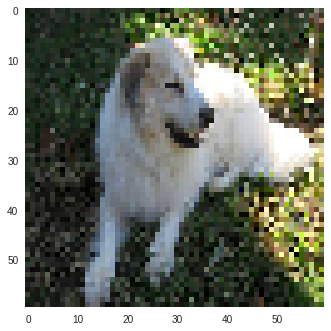


Expected : scottish_deerhound
Actual : afghan_hound
Incorrect Prediction


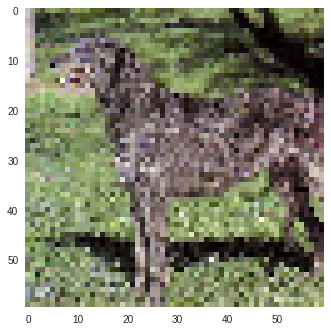


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


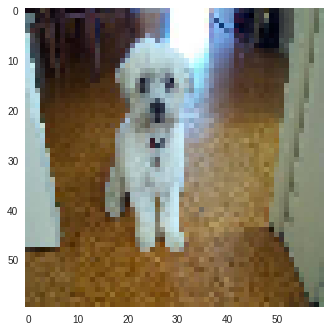


Expected : afghan_hound
Actual : afghan_hound
Correct Prediction


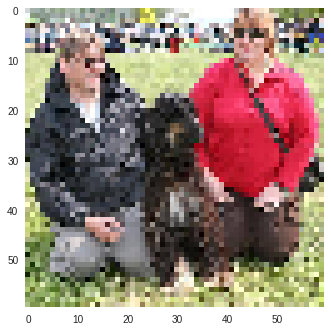


Expected : samoyed
Actual : scottish_deerhound
Incorrect Prediction


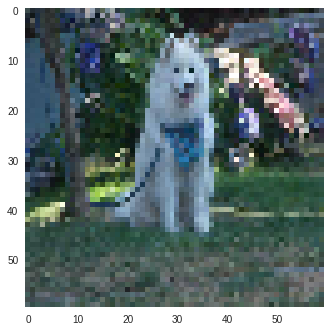


Expected : entlebucher
Actual : afghan_hound
Incorrect Prediction


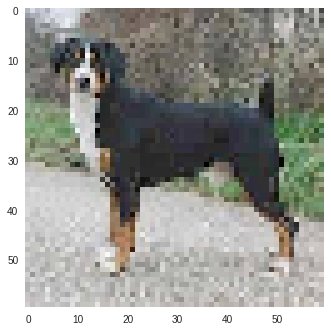


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


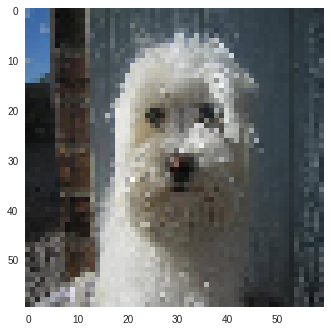


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


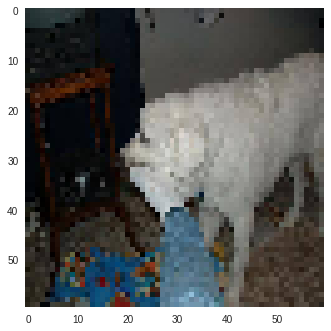


Expected : entlebucher
Actual : basenji
Incorrect Prediction


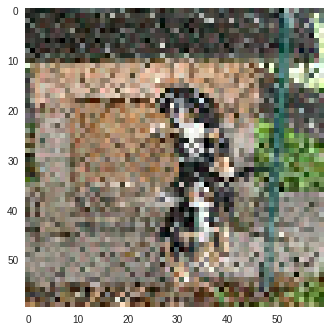


Expected : entlebucher
Actual : bernese_mountain_dog
Incorrect Prediction


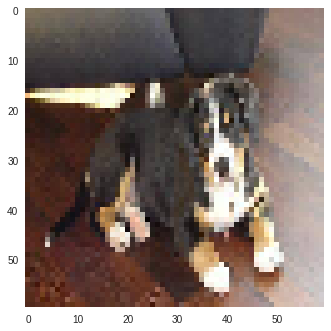


Expected : shih-tzu
Actual : maltese_dog
Incorrect Prediction


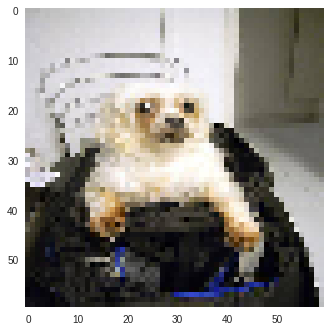


Expected : great_pyrenees
Actual : maltese_dog
Incorrect Prediction


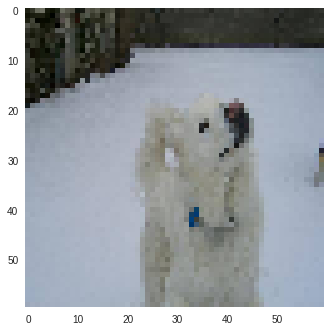


Expected : samoyed
Actual : samoyed
Correct Prediction


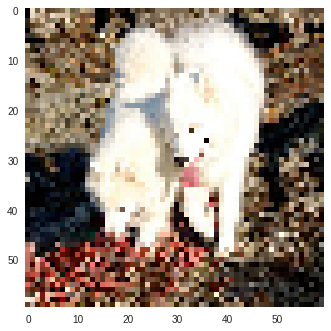


Expected : pomeranian
Actual : maltese_dog
Incorrect Prediction


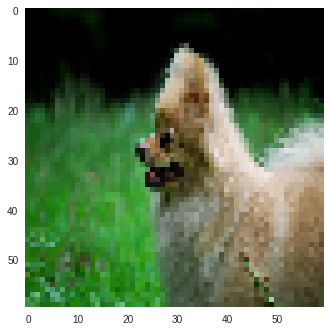


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


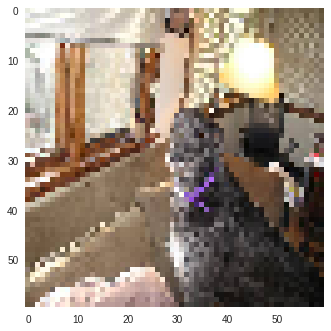


Expected : samoyed
Actual : samoyed
Correct Prediction


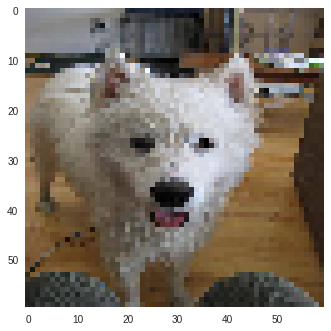


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


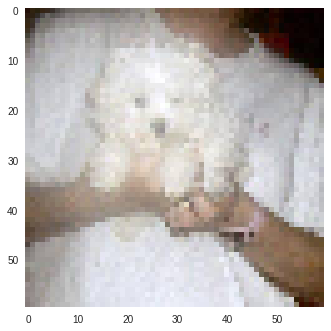


Expected : scottish_deerhound
Actual : great_pyrenees
Incorrect Prediction


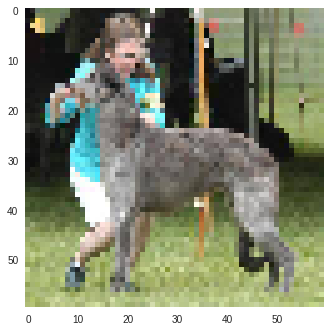


Expected : pomeranian
Actual : maltese_dog
Incorrect Prediction


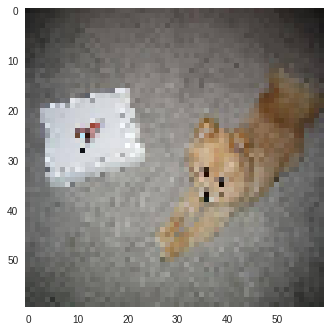


Expected : entlebucher
Actual : shih-tzu
Incorrect Prediction


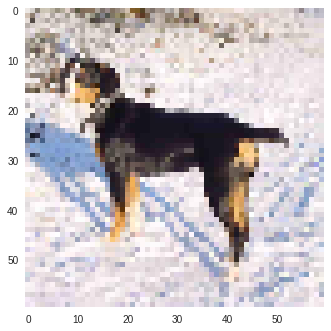


Expected : bernese_mountain_dog
Actual : afghan_hound
Incorrect Prediction


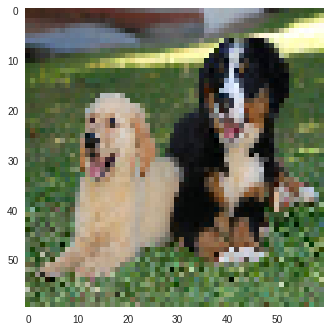


Expected : basenji
Actual : samoyed
Incorrect Prediction


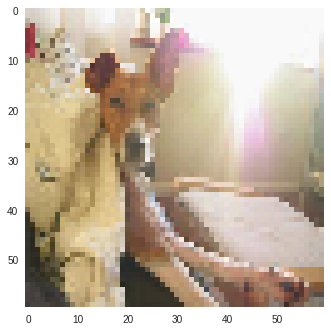


Expected : samoyed
Actual : samoyed
Correct Prediction


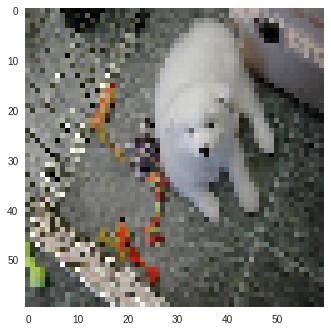


Expected : maltese_dog
Actual : shih-tzu
Incorrect Prediction


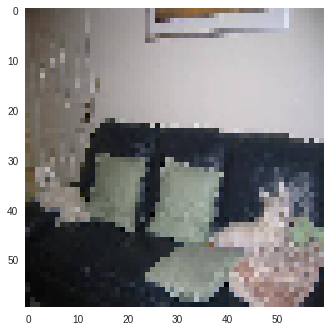


Expected : basenji
Actual : basenji
Correct Prediction


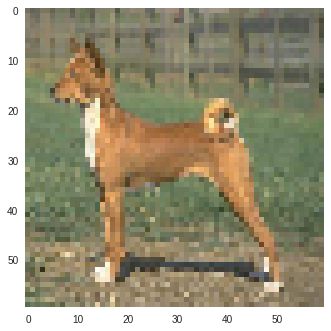


Expected : great_pyrenees
Actual : maltese_dog
Incorrect Prediction


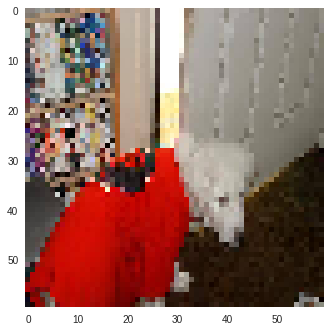


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


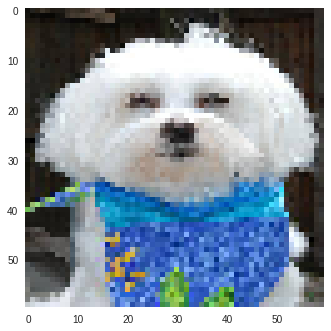


Expected : pomeranian
Actual : pomeranian
Correct Prediction


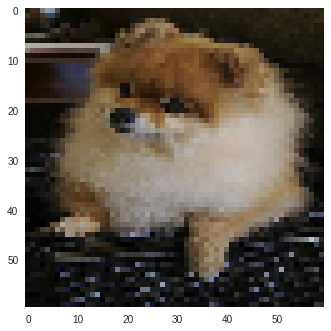


Expected : maltese_dog
Actual : basenji
Incorrect Prediction


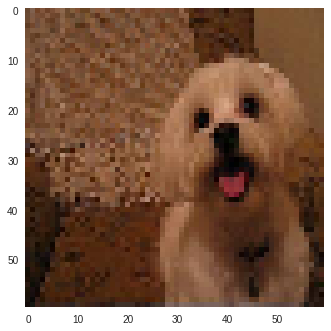


Expected : entlebucher
Actual : entlebucher
Correct Prediction


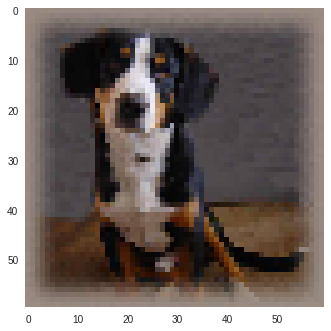


Expected : shih-tzu
Actual : pomeranian
Incorrect Prediction


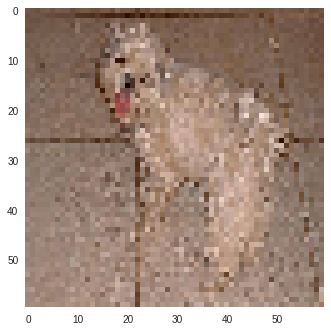


Expected : pomeranian
Actual : pomeranian
Correct Prediction


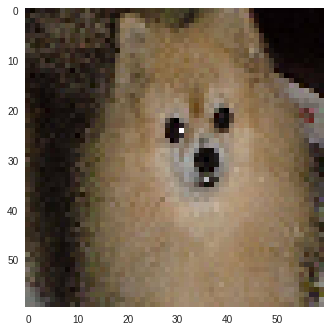


Expected : scottish_deerhound
Actual : maltese_dog
Incorrect Prediction


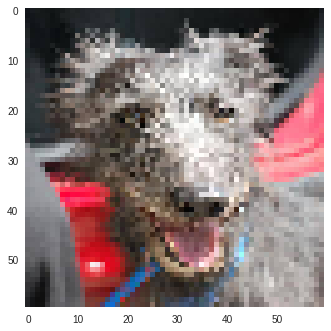


Expected : great_pyrenees
Actual : pomeranian
Incorrect Prediction


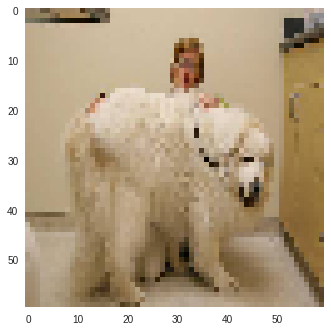


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


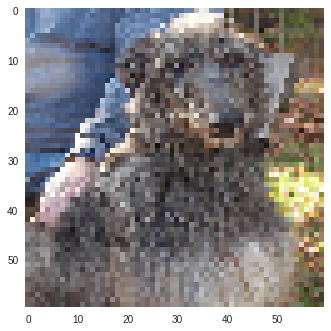


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


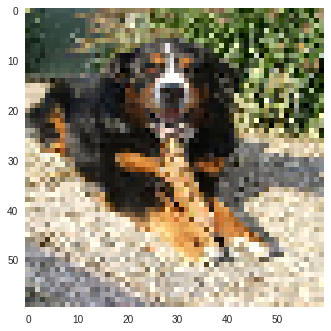


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


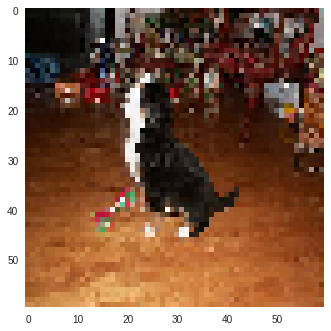


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


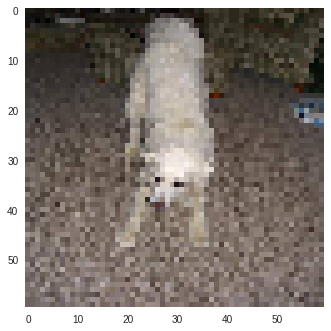


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


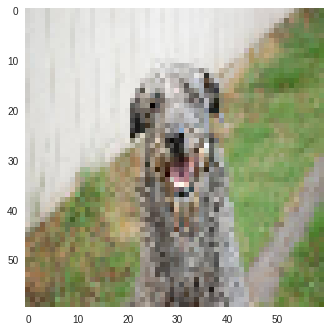


Expected : afghan_hound
Actual : afghan_hound
Correct Prediction


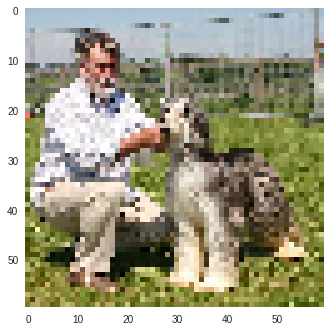


Expected : basenji
Actual : basenji
Correct Prediction


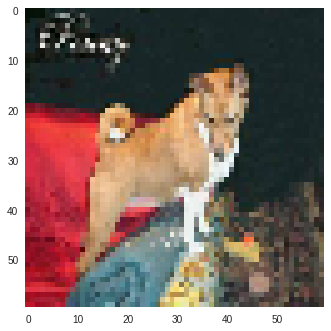


Expected : pomeranian
Actual : maltese_dog
Incorrect Prediction


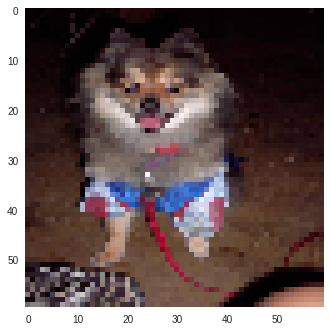


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


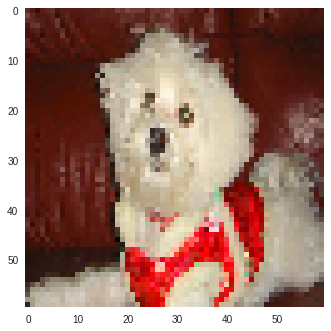


Expected : bernese_mountain_dog
Actual : entlebucher
Incorrect Prediction


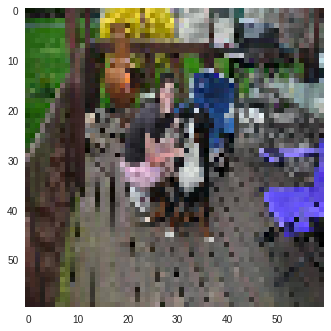


Expected : pomeranian
Actual : pomeranian
Correct Prediction


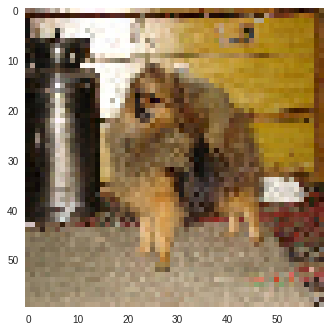


Expected : samoyed
Actual : maltese_dog
Incorrect Prediction


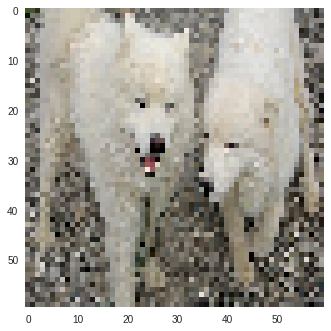


Expected : shih-tzu
Actual : scottish_deerhound
Incorrect Prediction


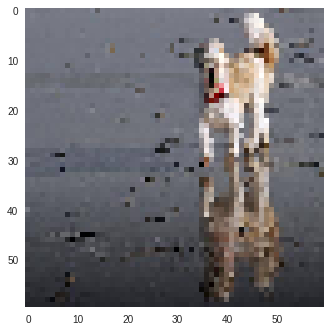


Expected : basenji
Actual : basenji
Correct Prediction


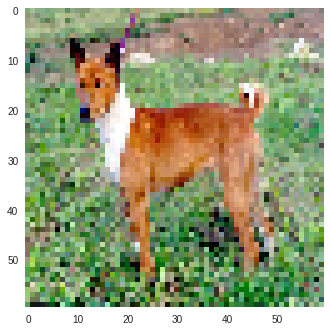


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


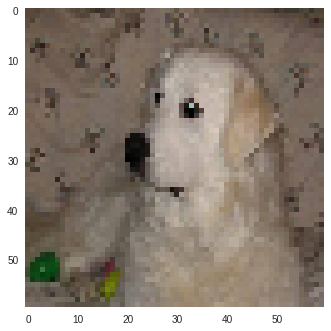


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


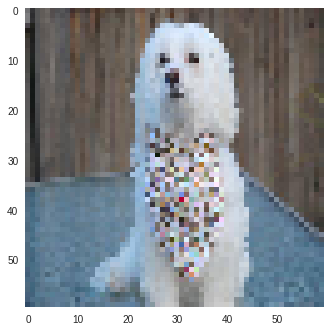


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


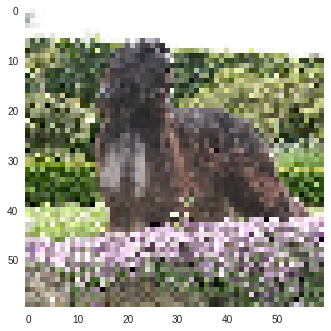


Expected : great_pyrenees
Actual : maltese_dog
Incorrect Prediction


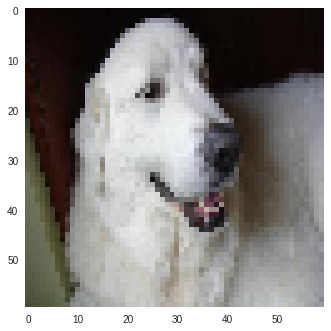


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


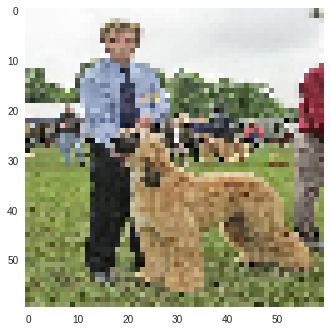


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


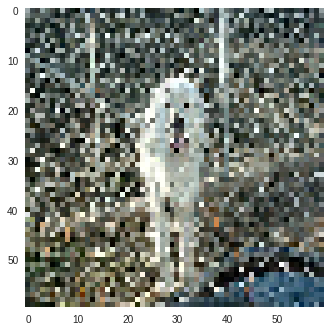


Expected : samoyed
Actual : entlebucher
Incorrect Prediction


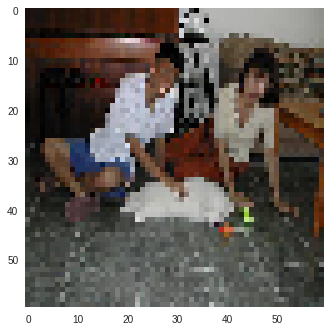


Expected : great_pyrenees
Actual : scottish_deerhound
Incorrect Prediction


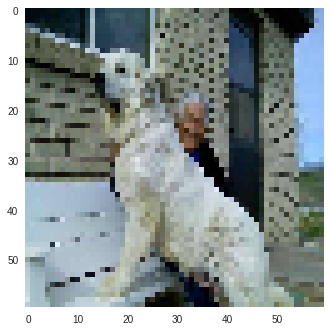


Expected : entlebucher
Actual : entlebucher
Correct Prediction


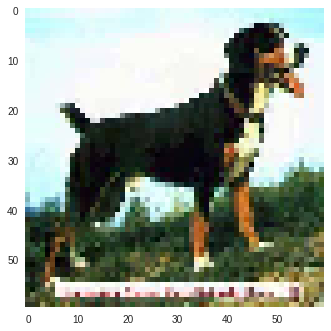


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


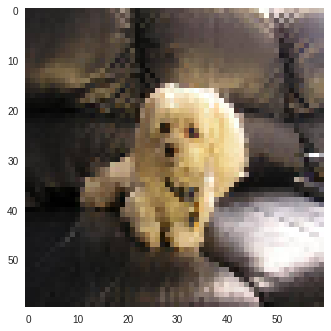


Expected : samoyed
Actual : samoyed
Correct Prediction


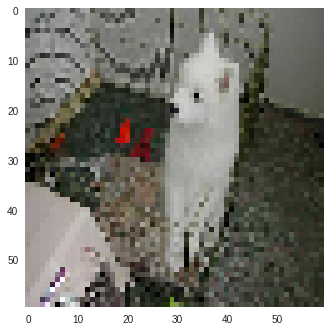


Expected : basenji
Actual : entlebucher
Incorrect Prediction


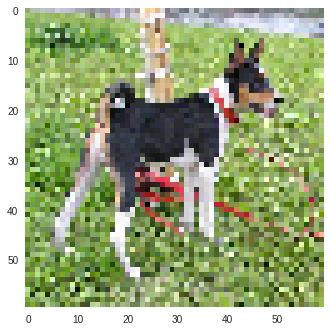


Expected : basenji
Actual : basenji
Correct Prediction


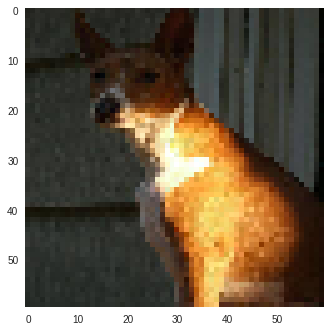


Expected : pomeranian
Actual : entlebucher
Incorrect Prediction


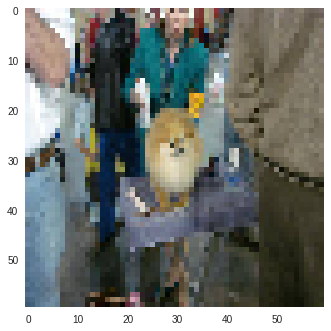


Expected : shih-tzu
Actual : shih-tzu
Correct Prediction


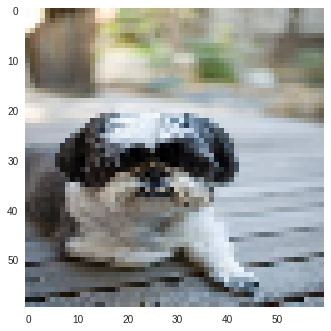


Expected : basenji
Actual : bernese_mountain_dog
Incorrect Prediction


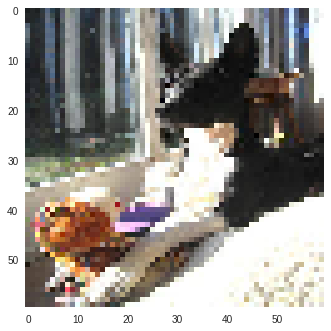


Expected : bernese_mountain_dog
Actual : bernese_mountain_dog
Correct Prediction


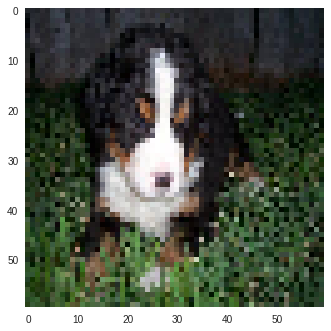


Expected : scottish_deerhound
Actual : entlebucher
Incorrect Prediction


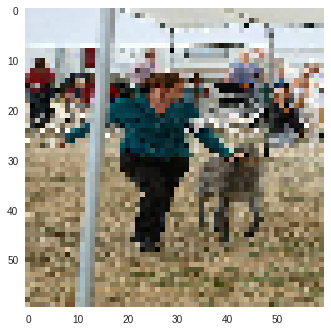


Expected : great_pyrenees
Actual : basenji
Incorrect Prediction


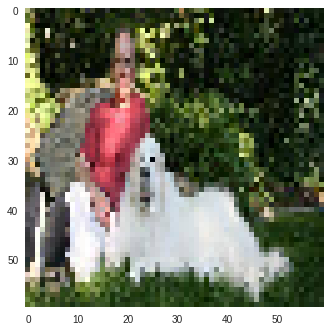


Expected : samoyed
Actual : shih-tzu
Incorrect Prediction


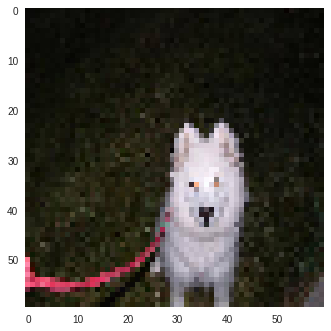


Expected : afghan_hound
Actual : great_pyrenees
Incorrect Prediction


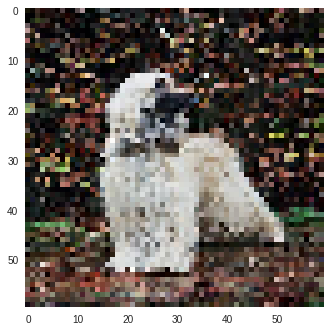


Expected : pomeranian
Actual : samoyed
Incorrect Prediction


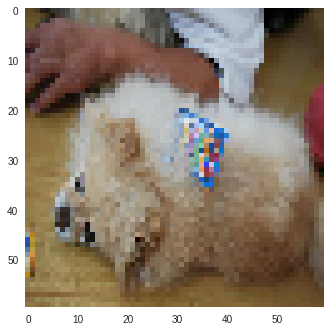


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


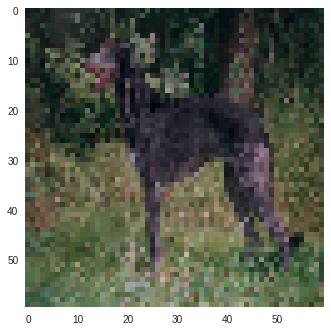


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


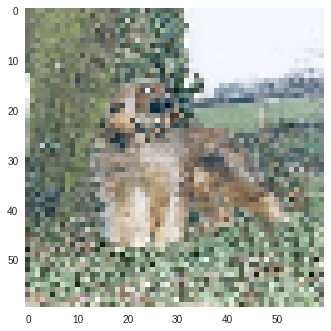


Expected : afghan_hound
Actual : bernese_mountain_dog
Incorrect Prediction


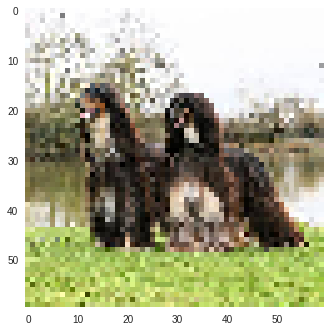


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


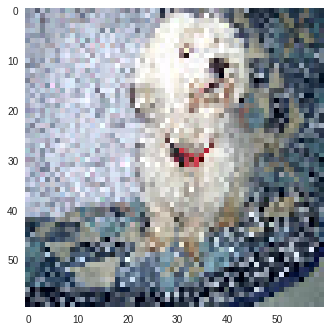


Expected : shih-tzu
Actual : maltese_dog
Incorrect Prediction


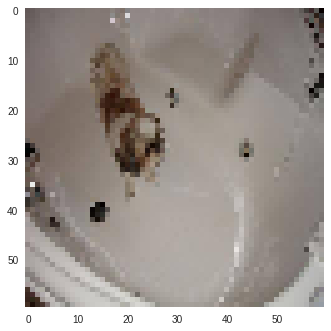


Expected : afghan_hound
Actual : entlebucher
Incorrect Prediction


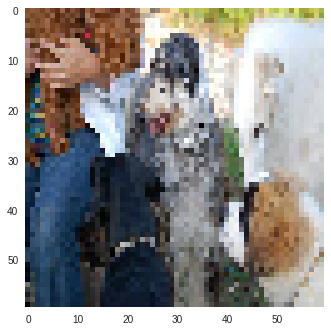


Expected : great_pyrenees
Actual : great_pyrenees
Correct Prediction


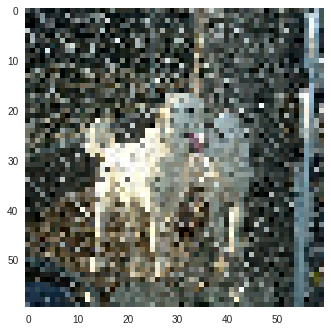


Expected : pomeranian
Actual : maltese_dog
Incorrect Prediction


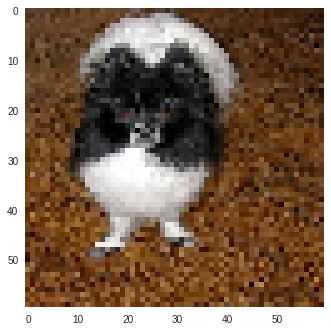


Expected : afghan_hound
Actual : afghan_hound
Correct Prediction


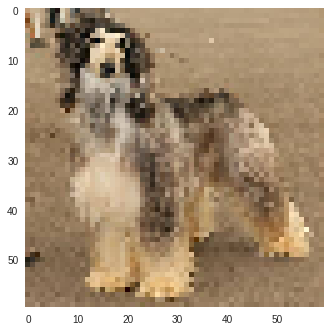


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


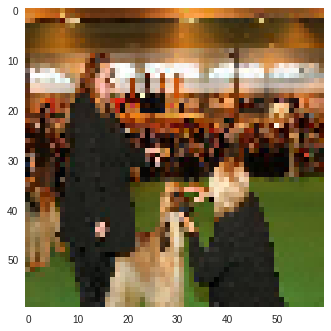


Expected : afghan_hound
Actual : samoyed
Incorrect Prediction


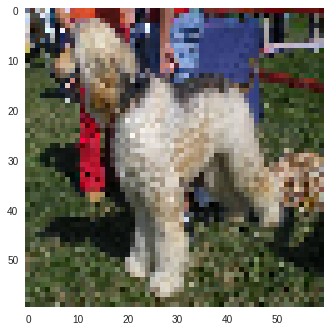


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


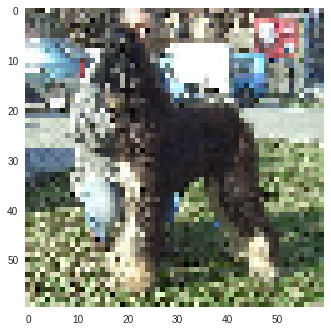


Expected : great_pyrenees
Actual : shih-tzu
Incorrect Prediction


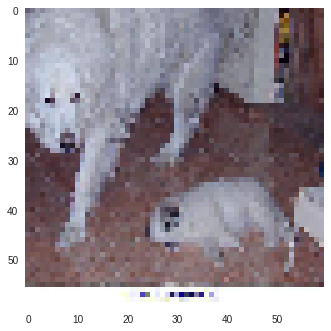


Expected : afghan_hound
Actual : pomeranian
Incorrect Prediction


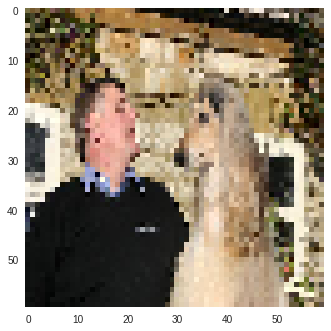


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


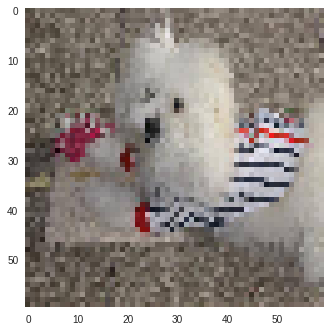


Expected : samoyed
Actual : samoyed
Correct Prediction


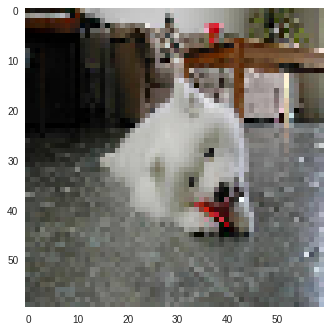


Expected : maltese_dog
Actual : scottish_deerhound
Incorrect Prediction


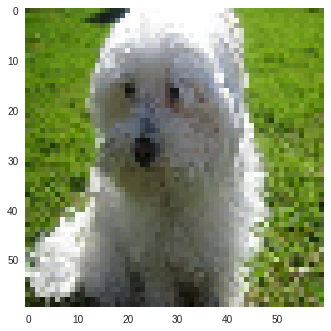


Expected : pomeranian
Actual : pomeranian
Correct Prediction


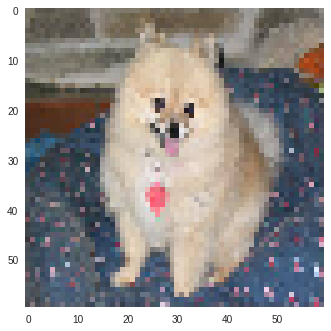


Expected : great_pyrenees
Actual : pomeranian
Incorrect Prediction


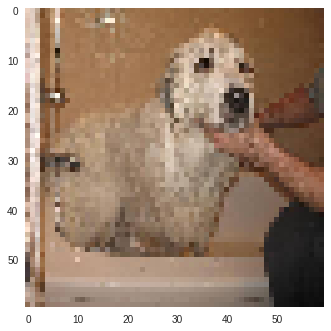


Expected : scottish_deerhound
Actual : scottish_deerhound
Correct Prediction


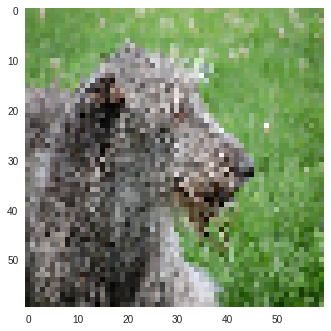


Expected : basenji
Actual : basenji
Correct Prediction


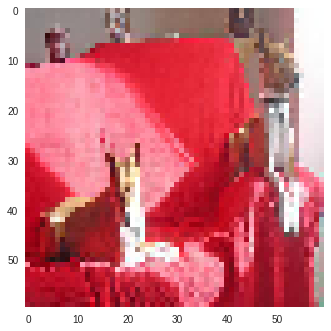


Expected : pomeranian
Actual : pomeranian
Correct Prediction


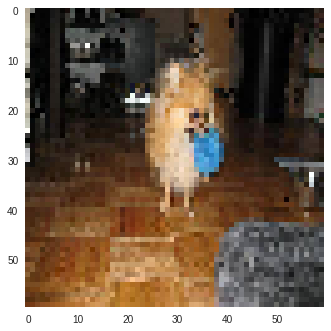


Expected : afghan_hound
Actual : scottish_deerhound
Incorrect Prediction


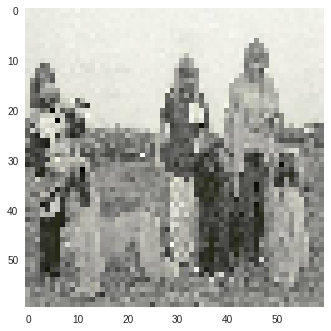


Expected : maltese_dog
Actual : samoyed
Incorrect Prediction


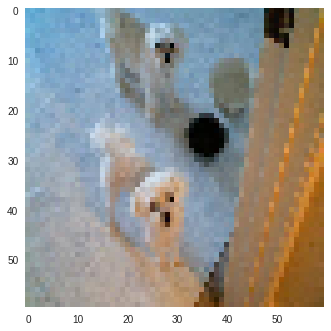


Expected : maltese_dog
Actual : pomeranian
Incorrect Prediction


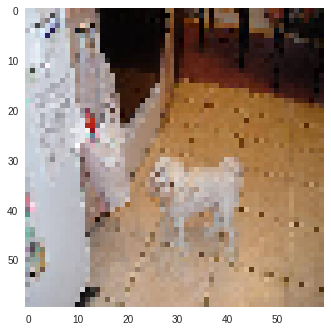


Expected : maltese_dog
Actual : maltese_dog
Correct Prediction


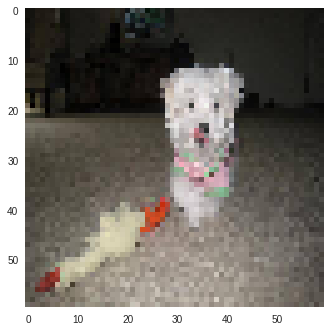


Expected : great_pyrenees
Actual : samoyed
Incorrect Prediction


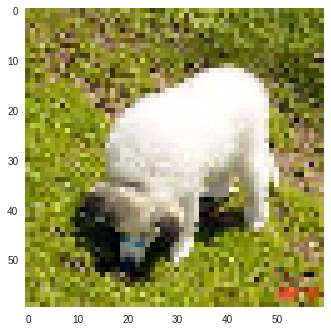


Expected : afghan_hound
Actual : shih-tzu
Incorrect Prediction


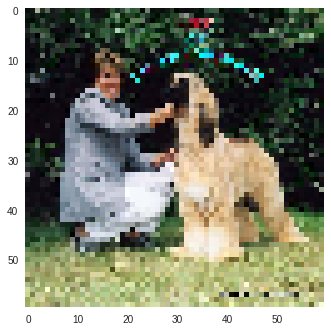


Expected : afghan_hound
Actual : afghan_hound
Correct Prediction


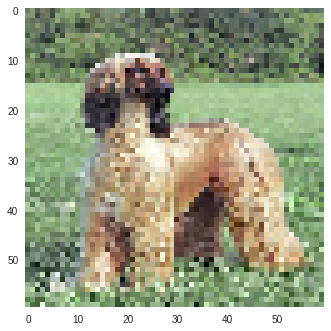


Expected : basenji
Actual : maltese_dog
Incorrect Prediction


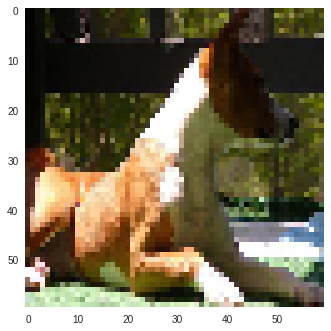


Expected : samoyed
Actual : maltese_dog
Incorrect Prediction


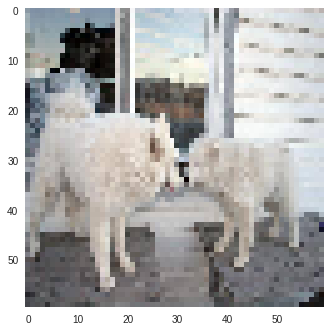


Expected : bernese_mountain_dog
Actual : shih-tzu
Incorrect Prediction


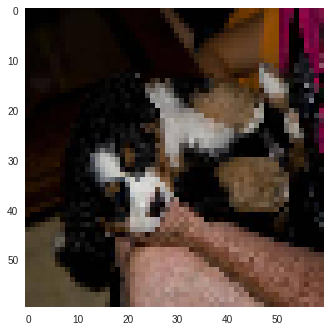

Got 123 correct out of 343 (35.860058309037896)


In [0]:
#from random import randint
correct_predictions = 0
number_of_test_images = len(df_validation_predictions_cls)
for i in range(number_of_test_images):
  #test= randint(0,276)
  expected = df_validation_expected_cls[i]
  actual = df_validation_predictions_cls[i]
  print(("\nExpected : {0}").format(labels_name[expected]))
  print(("Actual : {0}").format(labels_name[actual]))
  correct = expected == actual
  print("Correct Prediction" if correct else "Incorrect Prediction")
  if correct:
    correct_predictions += 1
  lum = X_validation[i,:,:,:]
  plt.imshow(lum)
  plt.grid(False)
  plt.show()
print("Got {} correct out of {} ({})".format(correct_predictions, number_of_test_images, correct_predictions/(number_of_test_images/100)))

##Transfer-Learning with Tensorflow for Poets




In [0]:
!git clone https://github.com/googlecodelabs/tensorflow-for-poets-2

fatal: destination path 'tensorflow-for-poets-2' already exists and is not an empty directory.


###Preprocessing

In [0]:
!unzip train.zip
!unzip labels.csv.zip

Archive:  train.zip
replace train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  labels.csv.zip
replace labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
%cd /content

import shutil

train_directory = 'train/'
train_new_directory = 'tensorflow-for-poets-2/train_new/'
test_new_directory = 'tensorflow-for-poets-2/test_new/'
train_to_test_ratio = 2

if not os.path.exists(train_new_directory):
  os.mkdir(train_new_directory)
if not os.path.exists(test_new_directory):
  os.mkdir(test_new_directory)

test_solutions = []
count = 0
for row in labels_filtered.iterrows():
  count += 1
  index, values = row
  image_id, breed = values
  if count % (train_to_test_ratio + 1) == 0:
    test_solutions.append((image_id, breed))
    destination_directory = test_new_directory
  else:
    destination_directory = train_new_directory
  if not os.path.exists(destination_directory + breed):
    print("Creating directory for breed", breed)
    os.mkdir(destination_directory + breed)
  source_path = train_directory + image_id + '.jpg'
  destination_path = destination_directory + breed + '/' + image_id + '.jpg'
  try:
      shutil.copy(source_path, destination_path)
      print("Copying image", image_id)
  except:
    print('Unexpected Error when copying file from {} to {}'
          .format(source_path, destination_path))

/content
Creating directory for breed basenji
Copying image 003df8b8a8b05244b1d920bb6cf451f9
Creating directory for breed scottish_deerhound
Copying image 0042188c895a2f14ef64a918ed9c7b64
Creating directory for breed maltese_dog
Copying image 00693b8bc2470375cc744a6391d397ec
Creating directory for breed shih-tzu
Copying image 0162b3e0144fb1d1ab82fbff3ace9938
Creating directory for breed samoyed
Copying image 01b36cb1b80ab8c3a7d2b7128ad21bdc
Creating directory for breed scottish_deerhound
Copying image 01e787576c003930f96c966f9c3e1d44
Creating directory for breed entlebucher
Copying image 01ee3c7ff9bcaba9874183135877670e
Copying image 021b5a49189665c0442c19b5b33e8cf1
Copying image 022b34fd8734b39995a9f38a4f3e7b6b
Creating directory for breed bernese_mountain_dog
Copying image 02d54f0dfb40038765e838459ae8c956
Copying image 02eef0f899b81ddf27a42641bc8db9ee
Creating directory for breed shih-tzu
Copying image 035f28d8ad34afaf7c8d276d6674bf8f
Creating directory for breed afghan_hound
Copying

In [0]:
% cd /content/tensorflow-for-poets-2
!python -m scripts.retrain \
  --bottleneck_dir=tf_files/bottlenecks \
  --how_many_training_steps=500 \
  --model_dir=tf_files/models/ \
  --summaries_dir=tf_files/training_summaries/"mobilenet_0.50_224" \
  --output_graph=tf_files/retrained_graph.pb \
  --output_labels=tf_files/retrained_labels.txt \
  --architecture="mobilenet_0.50_224" \
  --image_dir=train_new

/content/tensorflow-for-poets-2
>> Downloading mobilenet_v1_0.50_224_frozen.tgz 100.1%
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/content/tensorflow-for-poets-2/scripts/retrain.py", line 1326, in <module>
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)
  File "/usr/local/lib/python3.6/dist-packages/te

In [0]:
% cd /content/tensorflow-for-poets-2
!python -m scripts.label_image \
    --graph=tf_files/retrained_graph.pb  \
    --image=test_new/afghan_hound/09c62a1ff26b3e83a2d476c2add054b1.jpg 


/content/tensorflow-for-poets-2

Evaluation time (1-image): 0.166s

afghan hound (score=0.84671)
bernese mountain dog (score=0.14888)
scottish deerhound (score=0.00222)
entlebucher (score=0.00126)
basenji (score=0.00037)


The following is based off of the label_image script provided by TF-for poets

In [0]:
% cd /content/tensorflow-for-poets-2
import argparse
import sys
import time

import numpy as np
import tensorflow as tf

def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

def read_tensor_from_image_file(file_name, input_height=299, input_width=299,
				input_mean=0, input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
  else:
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0);
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label


/content/tensorflow-for-poets-2


In [0]:
import re
model_file = "tf_files/retrained_graph.pb" 
file_name = "test_new/afghan_hound/059a86d50634c78d5a18f918cb0b3f0d.jpg"

label_file = "tf_files/retrained_labels.txt"
input_height = 224
input_width = 224
input_mean = 128
input_std = 128
input_layer = "input"
output_layer = "final_result"

graph = load_graph(model_file)

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name);
output_operation = graph.get_operation_by_name(output_name);

regex = re.compile(r"[\W_]", re.IGNORECASE)
def labels_match(expected, actual):
  return regex.sub("", expected) == regex.sub("", actual)

num_correct = 0
total = len(test_solutions)
labels = load_labels(label_file)
with tf.Session(graph=graph) as sess:
  for row in test_solutions:
    image_id, breed = row
    file_name = "test_new/{}/{}.jpg".format(breed, image_id)
    t = read_tensor_from_image_file(file_name,
                                  input_height=input_height,
                                  input_width=input_width,
                                  input_mean=input_mean,
                                  input_std=input_std)

    results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: t})

    results = np.squeeze(results)
    
    actual = labels[results.argmax()]
    correct = labels_match(breed, actual)
    
    print("Expected:{}, Got:{}, {}"
          .format(breed, actual, "☺" if correct else "X"))
    
    if correct:
      num_correct += 1


print("Got {} correct out of {}, ({}%)".format(num_correct,
                                         total,
                                         (100 * num_correct/total)))

Expected:maltese_dog, Got:maltese dog, ☺
Expected:scottish_deerhound, Got:scottish deerhound, ☺
Expected:maltese_dog, Got:maltese dog, ☺
Expected:shih-tzu, Got:maltese dog, X
Expected:maltese_dog, Got:maltese dog, ☺
Expected:basenji, Got:basenji, ☺
Expected:maltese_dog, Got:maltese dog, ☺
Expected:scottish_deerhound, Got:scottish deerhound, ☺
Expected:maltese_dog, Got:maltese dog, ☺
Expected:bernese_mountain_dog, Got:bernese mountain dog, ☺
Expected:great_pyrenees, Got:great pyrenees, ☺
Expected:basenji, Got:basenji, ☺
Expected:pomeranian, Got:pomeranian, ☺
Expected:shih-tzu, Got:shih tzu, ☺
Expected:samoyed, Got:great pyrenees, X
Expected:afghan_hound, Got:afghan hound, ☺
Expected:samoyed, Got:great pyrenees, X
Expected:maltese_dog, Got:maltese dog, ☺
Expected:scottish_deerhound, Got:scottish deerhound, ☺
Expected:scottish_deerhound, Got:scottish deerhound, ☺
Expected:shih-tzu, Got:shih tzu, ☺
Expected:entlebucher, Got:entlebucher, ☺
Expected:samoyed, Got:samoyed, ☺
Expected:entlebuch

In [0]:
!zip -r /content/tf4p2.zip /content/tensorflow-for-poets-2/tf_files

  adding: content/tensorflow-for-poets-2/tf_files/ (stored 0%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/ (stored 0%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/samoyed/ (stored 0%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/samoyed/a3c86eed8bd50060f0d3e8d03c600087.jpg_mobilenet_0.50_224.txt (deflated 52%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/samoyed/c38e77ac6a0ee0c8ff5fdcd1df42f6f0.jpg_mobilenet_0.50_224.txt (deflated 52%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/samoyed/b6a6bf17290dcccfb399b78cfeb2524d.jpg_mobilenet_0.50_224.txt (deflated 52%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/samoyed/b9757ae6aae924b0b5771d9dcd7590ca.jpg_mobilenet_0.50_224.txt (deflated 52%)
  adding: content/tensorflow-for-poets-2/tf_files/bottlenecks/samoyed/1c80cbd184334b339e5eba8aaa6ae929.jpg_mobilenet_0.50_224.txt (deflated 52%)
  adding: content/tensorflow-for-poets-2/tf_files/bott